# The purpose of this notebook

This is the final notebook that makes figures for the paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
n_boot = 10000

In [4]:
import string

import numpy as np
np.set_printoptions(precision=3)

import pandas as pd
import scipy.stats as st
import statsmodels.stats.multitest as mt

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

from scipy import stats

import suppression as s
import utils

In [5]:
pd.__version__

'0.24.2'

In [6]:
sns.__version__

'0.9.0'

In [8]:
gaba_fn = 'gaba_data_2019.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [9]:
sdf = utils.load_psychophys(supp_fn)
gaba_col = 'mean_occ_all' #'motor' # or 'occ_binoc', 'mean_occ_all', 'motor'
gdf = utils.load_gaba(gaba_fn, gaba_col)
sdf.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


In [10]:
gdf.Population = gdf.Population.astype('category')
gdf.Population.cat.categories # 0 AMB 1 CON
gdf.Population = gdf.Population.cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted persons'])

In [11]:
demos = pd.read_csv('demos.csv', lineterminator="\r")
# 1 = amb, 0 = control
subs_to_swap_eyes = demos[demos.swapNDE_EY==1].initials.unique() # subjects whose NDE/DE assignment is wrong in sdf
print(subs_to_swap_eyes)
demos

['ai' 'ct' 'dl' 'ei' 'kw' 'nl']


,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,AC_081714,36,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.204120,0.116910,0.321030,0.198,0.215
1,3,ai,AI_032814,29,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.223,0.236
2,6,as,AS_071814,39,1,female,1,PWA,3,1,...,0,1,left,iodAcuity,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,BI_050514,52,1,female,1,PWA,3,1,...,1,2,right,iodAcuity,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,CH_072314,33,1,female,1,PWA,3,2,...,0,1,left,iodAcuity,0,-0.084939,1.176091,1.261030,0.184,NaN
5,11,cr,CR_060414,38,2,male,0,NSP,2,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.201,0.204
6,12,cs,CS_072714,46,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.096910,0.281030,0.377940,0.220,NaN
7,13,ct,CT_032514,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.208,0.208
8,14,dl,DL_082214,67,2,male,0,NSP,2,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.220,0.216
9,16,ei,EI_030214,39,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.200,0.203


In [12]:
demos[demos.initials=='nl']

,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
22,34,nl,NL_060814,33,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.21,0.218


### Set variables used for graphing

In [13]:
colors_amb = ["#3274a1","#72b4e1"]
colors_con = ["#e1812c", "#ffc68c"]
colors4 = colors_amb + colors_con
traces4 = ['Amblyope-De', 'Amblyope-Nde', 'Control-De', 'Control-Nde']
traces_graph4 = [f"Persons with\nAmblyopia, DE", f"Persons with\nAmblyopia, NDE", \
                 f"Normally-sighted\npersons, DE", f"Normally-sighted\npersons, NDE"]
plot_dir = f"plots/redo-202001-{gaba_col}-fixeyes"

## Analyze tasks separately (before subsetting to include common subjects)##

In [14]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em'
 'es' 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv'
 'nl' 'nn' 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd'
 'gm' 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn'
 'sd' 'tt' 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

In [15]:
gdf

,subjName,Population,Presentation,GABA
2,ac,Persons with Amblyopia,mean_occ_all,0.198
6,am,Persons with Amblyopia,mean_occ_all,0.194
10,as,Persons with Amblyopia,mean_occ_all,0.217
14,bi,Persons with Amblyopia,mean_occ_all,0.205
18,ch,Persons with Amblyopia,mean_occ_all,0.184
22,cs,Persons with Amblyopia,mean_occ_all,0.220
26,em,Persons with Amblyopia,mean_occ_all,0.185
30,gd,Persons with Amblyopia,mean_occ_all,0.197
34,jv,Persons with Amblyopia,mean_occ_all,0.201
38,ks,Persons with Amblyopia,mean_occ_all,0.207


#### Remove AM and TT based on discussions with Kelly 12/2019.

In [16]:
gdf_reduced = gdf[(gdf.subjName != 'am') & (gdf.subjName !='tt')]
pop_group_reduced = gdf_reduced.groupby("Population")
pop_group_reduced.describe()

GABA                                             \
                         count      mean       std    min      25%    50%   
Population                                                                  
Persons with Amblyopia    14.0  0.202929  0.012092  0.184  0.19725  0.203   
Normally-sighted persons  15.0  0.205800  0.009443  0.193  0.19850  0.203   

                                          
                              75%    max  
Population                                
Persons with Amblyopia    0.21375  0.220  
Normally-sighted persons  0.21100  0.223

In [17]:
#print(*pop_group_reduced['GABA'])
gaba_per_group = [col for col_name, col in pop_group_reduced['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-0.7154537449760943 0.48047050303580596


In [18]:
pop_group = gdf.groupby("Population")
pop_group.describe(percentiles=[.5])

GABA                                          
                         count      mean       std    min     50%    max
Population                                                              
Persons with Amblyopia    16.0  0.199813  0.015276  0.162  0.2005  0.220
Normally-sighted persons  15.0  0.205800  0.009443  0.193  0.2030  0.223

In [19]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-1.30189405829905 0.20319932494233123


**Thus we find no significant difference in GABA levels between CON and AMB regardless of whether AM and TT are included. At this point we may as well proceed with gdf_reduced only.**

### GABA violin plot, all subjects

In [20]:
gdf = gdf_reduced.copy()
gaba_df_immutable = gdf_reduced.copy()
gaba_df_immutable.groupby("Population").describe() # Shoud be 14 PWA due to AM, TT exclusion

GABA                                             \
                         count      mean       std    min      25%    50%   
Population                                                                  
Persons with Amblyopia    14.0  0.202929  0.012092  0.184  0.19725  0.203   
Normally-sighted persons  15.0  0.205800  0.009443  0.193  0.19850  0.203   

                                          
                              75%    max  
Population                                
Persons with Amblyopia    0.21375  0.220  
Normally-sighted persons  0.21100  0.223

#### Figure 4

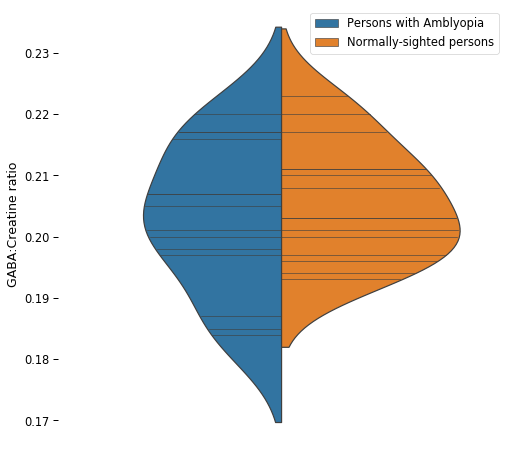

In [21]:
with s.PdfPages(f"{plot_dir}/figure04_gaba_diffs_n{n_gaba_subjs}.pdf") as pdf:
    #with sns.plotting_context(context=None, font_scale=1.3):
    sns.set_context(context="paper", font_scale=1.3)
    fig = plt.figure(figsize=(8,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gaba_df_immutable,split=True,inner='stick',ax=ax,legend=False)
    ax.legend()
    ax.xaxis.set_visible(False)
    ax.set_ylabel('GABA:Creatine ratio')
    sns.despine(left=True, bottom=True, right=True)
    #ax.set_yticklabels([])
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

### Note: the subject with the lowest GABA:Cr ('tt', .162) is not in the psychophysics data

# Select one psychophysical task's data #

In [22]:
task = 'SS' # 'SS'
sdf = sdf[sdf['Task']==task]
df_to_model = sdf.copy() # make a deep copy

In [23]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


In [24]:
n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
amb_subjs = np.unique(df_to_model[df_to_model["Population"]=="Amblyope"]["Subject"])
print(amb_subjs)
n_amb_subjs_thistask = len(amb_subjs)
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

['ah' 'am' 'bi' 'cl' 'eg' 'em' 'gd' 'jv' 'li' 'mg' 'mv' 'rn' 'sd']
There are 35 subjects for Task SS, of which 13 are Amblyopes.


### Verifying baselines based on KB feedback about fig R2

In [25]:
onecond = df_to_model[(df_to_model['Presentation']=='nMono') & (df_to_model['Orientation']=='Iso')]

In [26]:
cnde_subs = onecond[onecond['Trace']=='Control-Nde'].Subject.unique()

In [27]:
cde_subs = onecond[onecond['Trace']=='Control-De'].Subject.unique()

In [28]:
np.setdiff1d(cnde_subs, cde_subs)

array(['ap', 'bo', 'gw', 'ke', 'nn', 'tj'], dtype=object)

In [29]:
onecond.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace'])['BaselineThresh'].describe()

count      mean  \
Task Orientation Presentation Population Eye Trace                           
SS   Iso         nMono        Amblyope   De  Amblyope-De    53.0  6.201226   
                                         Nde Amblyope-Nde   54.0  7.201574   
                              Control    De  Control-De     54.0  6.306926   
                                         Nde Control-Nde    85.0  5.879106   

                                                                std    min  \
Task Orientation Presentation Population Eye Trace                           
SS   Iso         nMono        Amblyope   De  Amblyope-De   1.216117  4.063   
                                         Nde Amblyope-Nde  2.227975  4.558   
                              Control    De  Control-De    1.449616  4.033   
                                         Nde Control-Nde   1.339842  3.124   

                                                             25%    50%  \
Task Orientation Presentation Population Eye Trace                        
SS   Iso         nMono        Amblyope   De  Amblyope-De   5.949  6.262   
                                         Nde Amblyope-Nde  5.944  6.787   
                              Control    De  Control-De    5.478  6.458   
                                         Nde Control-Nde   5.006  5.741   

                                                             75%     max  
Task Orientation Presentation Population Eye Trace                        
SS   Iso         nMono        Amblyope   De  Amblyope-De   6.826   7.827  
                                         Nde Amblyope-Nde  7.834  13.226  
                              Control    De  Control-De    6.892   9.987  
                                         Nde Control-Nde   6.405   8.794

In [30]:
thresh_noswap = onecond.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace',"Subject"])['BaselineThresh'].mean().reset_index()

In [31]:
thresh_noswap.head()

,Task,Orientation,Presentation,Population,Eye,Trace,Subject,BaselineThresh
0,SS,Iso,nMono,Amblyope,De,Amblyope-De,ah,7.590
1,SS,Iso,nMono,Amblyope,De,Amblyope-De,am,7.532
2,SS,Iso,nMono,Amblyope,De,Amblyope-De,bi,7.827
3,SS,Iso,nMono,Amblyope,De,Amblyope-De,cl,6.709
4,SS,Iso,nMono,Amblyope,De,Amblyope-De,eg,6.826


In [32]:
eye_counts = thresh_noswap['Subject'].value_counts().reset_index()

In [33]:
eye_counts

,index,Subject
0,am,2
1,rn,2
2,yl,2
3,nl,2
4,kw,2
5,mk,2
6,ls,2
7,li,2
8,em,2
9,ei,2


In [34]:
nounpaired = (eye_counts[eye_counts.Subject==2])['index'].unique()

In [35]:
nounpaired

array(['am', 'rn', 'yl', 'nl', 'kw', 'mk', 'ls', 'li', 'em', 'ei', 'dl',
       'jd', 'ai', 'jv', 'ct', 'gd', 'cr', 'bi', 'sd', 'se', 'tm', 'mv',
       'mg', 'ah', 'es', 'cl', 'eg', 'gm', 'ms'], dtype=object)

In [36]:
thresh_noswap_nounpaired = thresh_noswap[thresh_noswap['Subject'].isin(nounpaired)]

In [37]:
thresh_noswap.groupby(['Trace']).mean().reset_index()

,Trace,BaselineThresh
0,Amblyope-De,6.136462
1,Amblyope-Nde,7.318385
2,Control-De,6.309750
3,Control-Nde,5.894955


In [38]:
thresh_noswap_nounpaired.groupby(['Trace']).describe()

BaselineThresh                                              \
                      count      mean       std    min      25%     50%   
Trace                                                                     
Amblyope-De            13.0  6.136462  1.280663  4.063  5.94900  6.2620   
Amblyope-Nde           13.0  7.318385  2.364243  4.558  5.94400  6.7870   
Control-De             16.0  6.309750  1.559247  4.033  5.42650  6.0295   
Control-Nde            16.0  5.921750  1.467759  3.124  5.20325  5.6900   

                               
                  75%     max  
Trace                          
Amblyope-De   6.82600   7.827  
Amblyope-Nde  7.83400  13.226  
Control-De    6.90475   9.987  
Control-Nde   6.68325   8.794

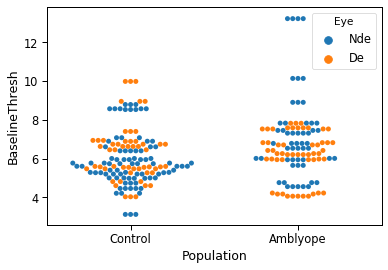

In [39]:
sns.swarmplot(data=onecond, x="Population", y="BaselineThresh", hue="Eye")

### This is where the NDE/DE should be switched based on KB findings (only affects Controls, luckily)

But as the above plot shows, there are many more in Control-Nde than Control-De

In [40]:
def swap_eyevars(df, subs=subs_to_swap_eyes):
    #print(df, df['Subject'], len(df), sep='\n')
    if df['Subject'] in subs: # fix here
        print(df['Subject'], "SWAP!")
        if df['Eye'] == "De":
            df['Eye'] = "Nde"
            df['Trace'] = df['Trace'].replace('-De', '-Nde')
        else:
            df['Eye'] = "De"
            df['Trace'] = df['Trace'].replace('-Nde', '-De')
    return df

def fix_eyes(df):
    disp_cols = ['Subject','Eye','Trace','BaselineThresh']
    rows_to_change = df_to_model[df_to_model.Subject.isin(subs_to_swap_eyes)]
    print(rows_to_change[disp_cols])
    assert(np.all(rows_to_change.Population == 'Control')) # should only affect controls
    assert(np.all(rows_to_change.Trace.isin(['Control-De','Control-Nde']))) # these should be swapped along w/ Eye
    fixed = df.apply(swap_eyevars, axis=1)
    print(fixed[disp_cols])
    return fixed

df_to_model_fixeyes = fix_eyes(df_to_model)

    Subject  Eye        Trace  BaselineThresh
0        ai  Nde  Control-Nde           6.900
1        ai  Nde  Control-Nde           6.900
2        ai  Nde  Control-Nde           6.900
17       ct  Nde  Control-Nde           8.794
18       ct  Nde  Control-Nde           8.794
19       ct  Nde  Control-Nde           8.794
20       dl  Nde  Control-Nde           5.772
21       dl  Nde  Control-Nde           5.772
22       dl  Nde  Control-Nde           5.772
23       dl  Nde  Control-Nde           5.772
24       dl  Nde  Control-Nde           5.772
25       ei  Nde  Control-Nde           4.985
26       ei  Nde  Control-Nde           4.985
27       ei  Nde  Control-Nde           4.985
51       kw  Nde  Control-Nde           5.292
52       kw  Nde  Control-Nde           5.292
53       kw  Nde  Control-Nde           5.292
63       nl  Nde  Control-Nde           5.276
64       nl  Nde  Control-Nde           5.276
65       nl  Nde  Control-Nde           5.276
139      ai   De   Control-De     

### Toggle which version of the data to use, "fixed" eyes or not

In [41]:
df_to_model = df_to_model_fixeyes

# Preparation for Modeling

In [42]:
df_to_model.head() # note the first rows, they will tell if fixed - ai/Nde/6.9 -> ai/De/6.9 

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,De,Control,10.0,0.615,0.009,1.449,Control-De,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,De,Control,30.0,0.671,0.010,4.348,Control-De,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,De,Control,62.0,1.658,0.007,8.986,Control-De,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [43]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

groups_with_baseline = df_to_model.groupby(pp_gvars_base)

# Check if there are any conditions with only two data points
for gv, gr in groups_with_baseline:
    if len(gr)<=2:
        print(gv, gr)

### BaselineThresh analysis before we exclude bad fits; since this is observed not modeled its ok

In [44]:
print(pp_gvars_base)
pp_gvars_base_agg = [v for v in pp_gvars if v != 'Subject']

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [45]:
pp_gvars_base_agg

['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace']

In [46]:
for gv, g in df_to_model.groupby(pp_gvars_base_agg):
    print(gv, len(np.unique(g['BaselineThresh'])))

('SS', 'Cross', 'nDicho', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nDicho', 'Control', 'De', 'Control-De') 16
('SS', 'Cross', 'nDicho', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Cross', 'nMono', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nMono', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nMono', 'Control', 'De', 'Control-De') 16
('SS', 'Cross', 'nMono', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nDicho', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nDicho', 'Control', 'De', 'Control-De') 16
('SS', 'Iso', 'nDicho', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nMono', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nMono', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nMono', 'Control', 'De', 'Control-De') 16
('SS', 'Iso', 'nMono', 'Control', 'Nde', 'Control-Nde') 22


In [47]:
thresh_swap = df_to_model.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Subject','Eye', 'Trace'])['BaselineThresh'].mean().reset_index()
thresh_swap = thresh_swap[(thresh_swap.Orientation=="Iso")&(thresh_swap.Presentation=='nDicho')]
thresh_swap.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh
128,SS,Iso,nDicho,Amblyope,ah,De,Amblyope-De,7.590
129,SS,Iso,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558
130,SS,Iso,nDicho,Amblyope,am,De,Amblyope-De,7.532
131,SS,Iso,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827


In [48]:
eye_counts_swap = thresh_swap.Subject.value_counts()
subs_no_unpaired = eye_counts[eye_counts_swap.reset_index()['Subject']==2]['index'].unique()
print(subs_no_unpaired, len(subs_no_unpaired))

['am' 'rn' 'yl' 'nl' 'kw' 'mk' 'ls' 'li' 'em' 'ei' 'dl' 'jd' 'ai' 'jv'
 'ct' 'gd' 'cr' 'bi' 'sd' 'se' 'tm' 'mv' 'mg' 'ah' 'es' 'cl' 'eg' 'gm'
 'ms'] 29


In [49]:
thresh_swap_nounpaired = thresh_swap[thresh_swap.Subject.isin(subs_no_unpaired)]

In [50]:
pd.Series.value_counts(thresh_swap_nounpaired.Subject)

am    2
ct    2
yl    2
nl    2
kw    2
mk    2
ls    2
li    2
em    2
ei    2
dl    2
jd    2
ai    2
gd    2
rn    2
jv    2
ah    2
ms    2
gm    2
eg    2
cl    2
bi    2
cr    2
mg    2
mv    2
tm    2
se    2
sd    2
es    2
Name: Subject, dtype: int64

In [51]:
thresh_swap_nounpaired.groupby(['Trace']).describe()

BaselineThresh                                             \
                      count      mean       std    min      25%    50%   
Trace                                                                    
Amblyope-De            13.0  6.136462  1.280663  4.063  5.94900  6.262   
Amblyope-Nde           13.0  7.318385  2.364243  4.558  5.94400  6.787   
Control-De             16.0  6.153313  1.557727  4.033  5.27500  5.564   
Control-Nde            16.0  6.078188  1.495439  3.124  5.25825  6.207   

                              
                 75%     max  
Trace                         
Amblyope-De   6.8260   7.827  
Amblyope-Nde  7.8340  13.226  
Control-De    6.8940   9.987  
Control-Nde   6.7945   8.957

#### Calculate differences, ratios etc for each subject

In [52]:
baseline_df_withinsubject = thresh_swap_nounpaired.groupby(['Task', 'Orientation', 'Presentation', 'Population',
                                        'Subject']).apply(utils.get_interocular_baseline_diff, 'BaselineThresh')
baseline_df_withinsubject[(baseline_df_withinsubject.Population=="Amblyope") & (baseline_df_withinsubject.Eye=="De")]

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,BaselineDiff,BaselineRatio
128,SS,Iso,nDicho,Amblyope,ah,De,Amblyope-De,7.590,-3.032,0.600527
130,SS,Iso,nDicho,Amblyope,am,De,Amblyope-De,7.532,0.302,1.040096
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827,2.314,1.295643
134,SS,Iso,nDicho,Amblyope,cl,De,Amblyope-De,6.709,0.749,1.111641
136,SS,Iso,nDicho,Amblyope,eg,De,Amblyope-De,6.826,-0.039,0.994287
138,SS,Iso,nDicho,Amblyope,em,De,Amblyope-De,5.949,0.065,1.010926
140,SS,Iso,nDicho,Amblyope,gd,De,Amblyope-De,6.210,0.326,1.052496
142,SS,Iso,nDicho,Amblyope,jv,De,Amblyope-De,4.227,0.537,1.127040
144,SS,Iso,nDicho,Amblyope,li,De,Amblyope-De,4.063,3.253,1.800640
146,SS,Iso,nDicho,Amblyope,mg,De,Amblyope-De,4.174,1.480,1.354576


In [53]:
ade_threshs = baseline_df_withinsubject[(baseline_df_withinsubject.Population=="Amblyope") & (baseline_df_withinsubject.Eye=="De")]

In [54]:
baseline_df_reduced = baseline_df_withinsubject.groupby(pp_gvars_base_agg).apply(utils.describe_baselines).reset_index()

In [55]:
baseline_df_reduced.head()

,Task,Orientation,Presentation,Population,Eye,Trace,N,mean,std,SEM
0,SS,Iso,nDicho,Amblyope,De,Amblyope-De,13.0,6.136462,1.230422,0.341258
1,SS,Iso,nDicho,Amblyope,Nde,Amblyope-Nde,13.0,7.318385,2.271492,0.629998
2,SS,Iso,nDicho,Control,De,Control-De,16.0,6.153313,1.508262,0.377066
3,SS,Iso,nDicho,Control,Nde,Control-Nde,16.0,6.078188,1.447952,0.361988


In [56]:
baseline_plot_df = utils.make_baseline_df_to_plot(baseline_df_reduced, 'mean')

In [57]:
baseline_plot_df.head()

,Task,Orientation,Presentation,Population,Eye,Trace,N,mean,std,SEM,BaselineDiff,BaselineRatio
0,SS,Iso,nDicho,Amblyope,De,Amblyope-De,13.0,6.136462,1.230422,0.341258,1.181923,1.192607
1,SS,Iso,nDicho,Amblyope,Nde,Amblyope-Nde,13.0,7.318385,2.271492,0.629998,1.181923,1.192607
2,SS,Iso,nDicho,Control,De,Control-De,16.0,6.153313,1.508262,0.377066,-0.075125,0.987791
3,SS,Iso,nDicho,Control,Nde,Control-Nde,16.0,6.078188,1.447952,0.361988,-0.075125,0.987791


In [58]:
baseline_df_withinsubject_diffs = baseline_df_withinsubject.groupby(['Population','Subject'])['BaselineDiff','BaselineRatio'].mean().reset_index()
baseline_df_withinsubject_diffs

,Population,Subject,BaselineDiff,BaselineRatio
0,Amblyope,ah,-3.032,0.600527
1,Amblyope,am,0.302,1.040096
2,Amblyope,bi,2.314,1.295643
3,Amblyope,cl,0.749,1.111641
4,Amblyope,eg,-0.039,0.994287
5,Amblyope,em,0.065,1.010926
6,Amblyope,gd,0.326,1.052496
7,Amblyope,jv,0.537,1.127040
8,Amblyope,li,3.253,1.800640
9,Amblyope,mg,1.480,1.354576


###  What if we exclude subject 'ah' who looks like a real outlier?

In [59]:
adiff = baseline_df_withinsubject_diffs[(baseline_df_withinsubject_diffs.Population=='Amblyope') &
                                        (baseline_df_withinsubject_diffs.Subject!="ah")]
cdiff = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Population=='Control']

In [60]:
print("diffs: NDE-DE")
print(st.ttest_1samp(adiff['BaselineDiff'], popmean=0), len(adiff['BaselineDiff']))
print(st.ttest_1samp(cdiff['BaselineDiff'], popmean=0), len(cdiff['BaselineDiff']))
print(st.ttest_ind(adiff['BaselineDiff'], cdiff['BaselineDiff']))
print("\nratios: NDE/DE")
print(st.ttest_1samp(adiff['BaselineRatio'], popmean=1))
print(st.ttest_1samp(cdiff['BaselineRatio'], popmean=1))
print(st.ttest_ind(adiff['BaselineRatio'], cdiff['BaselineRatio']))

diffs: NDE-DE
Ttest_1sampResult(statistic=2.6072499345735856, pvalue=0.024376781394930578) 12
Ttest_1sampResult(statistic=-0.3914078163041463, pvalue=0.7009997608059425) 16
Ttest_indResult(statistic=2.9092346026494287, pvalue=0.007327833537838833)

ratios: NDE/DE
Ttest_1sampResult(statistic=2.6759182869040514, pvalue=0.021564848189685275)
Ttest_1sampResult(statistic=-0.22134622628575037, pvalue=0.8278078450518194)
Ttest_indResult(statistic=2.918520108625676, pvalue=0.0071661206911115246)


### Ok based on conversation with Michael, 'ah' is excluded now

In [61]:
baseline_df_withinsubject_diffs = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Subject != 'ah']
df_to_model = df_to_model[df_to_model.Subject!='ah']

### GABA vs baseline contrast threshold, before excluding bad fits

In [62]:
baseline_gaba_plot_df = df_to_model.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [63]:
simple_bg_df = baseline_gaba_plot_df.groupby(['Task','Orientation','Presentation','Population','Subject','Eye','Trace'])[['GABA','BaselineThresh']].agg(np.mean).reset_index()

In [64]:
simple_bg_df = simple_bg_df.rename(columns={"BaselineThresh":"value"})
simple_bg_df['measure'] = "BaselineThresh"
simple_bg_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,GABA,value,measure
0,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,NaN,7.532,BaselineThresh
1,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,NaN,7.834,BaselineThresh
2,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,0.205,7.827,BaselineThresh
3,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,0.205,10.141,BaselineThresh
4,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,NaN,6.709,BaselineThresh


In [65]:
len(simple_bg_df.Subject.unique())

34

In [66]:
simple_bg_df.Trace = simple_bg_df.Trace.astype('category')
simple_bg_df.Trace.cat.reorder_categories(traces4, inplace=True)
simple_bg_df.Trace.cat.rename_categories(traces_graph4, inplace=True)

In [67]:
simple_bg_df.groupby(['Task','Orientation','Presentation','Population', 'Eye', 'measure'])['value'].describe()

count      mean  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       Amblyope   De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                              Control    De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   
                 nMono        Amblyope   De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                              Control    De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   
     Iso         nDicho       Amblyope   De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                              Control    De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   
                 nMono        Amblyope   De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                              Control    De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   

                                                                  std    min  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       Amblyope   De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                              Control    De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   
                 nMono        Amblyope   De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                              Control    De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   
     Iso         nDicho       Amblyope   De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                              Control    De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   
                 nMono        Amblyope   De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                              Control    De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   

                                                                 25%     50%  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       Amblyope   De  BaselineThresh  5.51850  6.2360   
                                         Nde BaselineThresh  5.99650  7.0515   
                              Control    De  BaselineThresh  5.27500  5.5640   
                                         Nde BaselineThresh  5.05575  5.8465   
                 nMono        Amblyope   De  BaselineThresh  5.51850  6.2360   
                                         Nde BaselineThresh  5.99650  7.0515   
                              Control    De  BaselineThresh  5.27500  5.5640   
                                         Nde BaselineThresh  5.05575  5.8465   
     Iso         nDicho       Amblyope   De  BaselineThresh  5.51850  6.2360   
                                         Nde BaselineThresh  5.99650  7.0515   
                              Control    De  BaselineThresh  5.27500  5.5640   
                                         Nde BaselineThresh  5.05575  5.8465   
                 nMono        Amblyope   De  BaselineThresh

In [68]:
simple_bg_df_nonan = simple_bg_df[~np.isnan(simple_bg_df.GABA)]

In [69]:
simple_bg_df_nonan_onecond = (simple_bg_df_nonan[(simple_bg_df_nonan['Presentation']=='nDicho') & (simple_bg_df_nonan['Orientation']=='Iso')])

#### Figure 6 top

Text(0, 0.5, 'Baseline Contrast Discrimination Threshold (C%)')

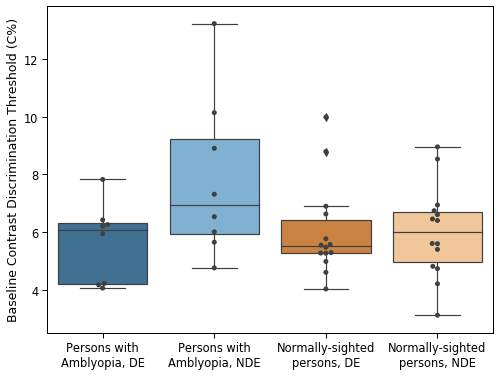

In [70]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(data=simple_bg_df_nonan_onecond, x='Trace', y='value', palette=colors4)
g = sns.swarmplot(data=simple_bg_df_nonan_onecond, x='Trace', y='value', color=".25")
g.set_xlabel('')
g.set_ylabel('Baseline Contrast Discrimination Threshold (C%)')

In [71]:
bg_groups = simple_bg_df_nonan.groupby(['Task','Orientation','Presentation','measure'])

In [72]:
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_{gaba_col}_baselines_noexc.pdf") as pdf:
    sns.set_context(context="paper", font_scale=1.3)
    i = 0 # only do the first group since they're all the same
    for gv, gr in bg_groups:
        if i==0:
            g = s.gaba_vs_psychophys_plot(gv, gr,
                        legend_box=[0.9, 0.60, 0.1, 0.15], log=True, ylim=(2.5, 20),
                        col="Population", hue="Trace",
                        sharex=False, sharey=False,
                        palette=colors4,
                        n_boot=n_boot, legend_img=False, markers=['o','^','o','^'])
            #g.fig.suptitle(f"{gv}", fontsize=10, y=0.999)
            g.set_titles("")
            g.fig.subplots_adjust(left=.08, wspace=.2, right=.85)
            pdf.savefig(g.fig)
            plt.close('all')
            i = 1

('SS', 'Cross', 'nDicho', 'BaselineThresh')

Percentiles for individual eye correlations:
Amb DE 
Observed value of -0.405 is greater than 0.148 of bootstrap distribution, corresponding to p=0.30.
Amb NDE 
Observed value of -0.214 is greater than 0.296 of bootstrap distribution, corresponding to p=0.59.
Con DE 
Observed value of 0.174 is greater than 0.727 of bootstrap distribution, corresponding to p=0.55.
Con NDE 
Observed value of 0.196 is greater than 0.752 of bootstrap distribution, corresponding to p=0.50.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of 0.190 is greater than 0.631 of bootstrap distribution, corresponding to p=0.74.
Con NDE vs DE 
Observed value of 0.022 is greater than 0.526 of bootstrap distribution, corresponding to p=0.95.
Pop Amb vs Con 
Observed value of 0.168 is greater than 0.601 of bootstrap distribution, corresponding to p=0.80.


In [73]:
np.zeros(4)

array([0., 0., 0., 0.])

In [74]:
baseline_df_withinsubject_diffs

,Population,Subject,BaselineDiff,BaselineRatio
1,Amblyope,am,0.302,1.040096
2,Amblyope,bi,2.314,1.295643
3,Amblyope,cl,0.749,1.111641
4,Amblyope,eg,-0.039,0.994287
5,Amblyope,em,0.065,1.010926
6,Amblyope,gd,0.326,1.052496
7,Amblyope,jv,0.537,1.127040
8,Amblyope,li,3.253,1.800640
9,Amblyope,mg,1.480,1.354576
10,Amblyope,mv,-0.037,0.993814


#### Figure 6 bottom

//anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
No handles with labels found to put in legend.


Text(0, 0.5, 'Interocular difference (NDE-DE) in baseline\ncontrast discrimination thresholds (C%)')

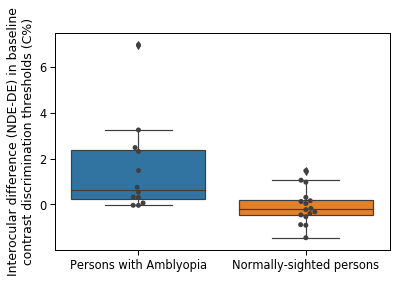

In [75]:
plt.figure(figsize=(6, 4))
baseline_df_withinsubject_diffs.Population = baseline_df_withinsubject_diffs.Population.astype('category').cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted persons'])
g = sns.boxplot(data=baseline_df_withinsubject_diffs, x='Population', y='BaselineDiff')
g = sns.swarmplot(data=baseline_df_withinsubject_diffs, x='Population', y='BaselineDiff', color=".25")
g.legend().remove()
#g.legend().set_title('')
g.set_xlabel('')
g.set_ylabel('Interocular difference (NDE-DE) in baseline\ncontrast discrimination thresholds (C%)')

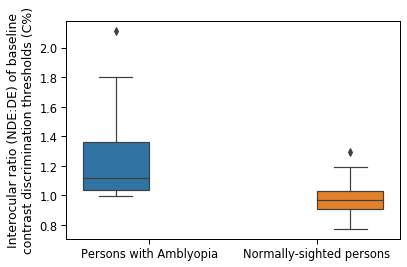

In [76]:
g = sns.boxplot(data=baseline_df_withinsubject_diffs, x='Population', y='BaselineRatio', hue='Population')
g.legend().remove()
g.set_xlabel('')
g.set_ylabel('Interocular ratio (NDE:DE) of baseline\ncontrast discrimination thresholds (C%)')
#g.set_yscale('log')
#g.set_ylim(0.5, 3)
#g.get_yaxis().set_major_locator(tick.LogLocator(subs=range(1, 10)))
g.get_yaxis().set_major_formatter(tick.ScalarFormatter())


In [77]:
baseline_df_withinsubject_diffs.groupby(['Population']).describe()

BaselineDiff                                      \
                                count      mean       std    min      25%   
Population                                                                  
Persons with Amblyopia           12.0  1.533083  2.036919 -0.039  0.24275   
Normally-sighted persons         16.0 -0.075125  0.767741 -1.453 -0.47700   

                                                BaselineRatio            \
                            50%      75%    max         count      mean   
Population                                                                
Persons with Amblyopia    0.643  2.35625  6.964          12.0  1.273315   
Normally-sighted persons -0.198  0.19950  1.473          16.0  0.992533   

                                                                            \
                               std       min       25%       50%       75%   
Population                                                                   
Persons with Amblyopia    0.353819  0.993814  1.032803  1.119341  1.362562   
Normally-sighted persons  0.134933  0.774609  0.909571  0.967698  1.032396   

                                    
                               max  
Population                          
Persons with Amblyopia    2.112105  
Normally-sighted persons  1.295486

## Actual fitting of model to contrast sensitivity curves
### Linear model using statsmodels

In [78]:
lin_results = groups_with_baseline.apply(utils.linear_fit_params, 'RelMaskContrast', 'ThreshElev').reset_index()

In [79]:
lin_results.head(n=16)

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,7.532,0.473458,0.008358,0.150669
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,1.035803,0.079161,0.878492
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,0.859762,0.014954,0.546837
5,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,0.712554,0.244377,0.992124
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
7,SS,Cross,nDicho,Amblyope,cl,Nde,Amblyope-Nde,7.458,1.044474,0.761080,0.943153
8,SS,Cross,nDicho,Amblyope,eg,De,Amblyope-De,6.826,0.986000,0.039389,0.722331
9,SS,Cross,nDicho,Amblyope,eg,Nde,Amblyope-Nde,6.787,1.004564,0.026249,0.659700


In [80]:
np.count_nonzero(lin_results.rsquared>.999999)

0

In [81]:
lin_results.rsquared.mean()

0.8354424459253054

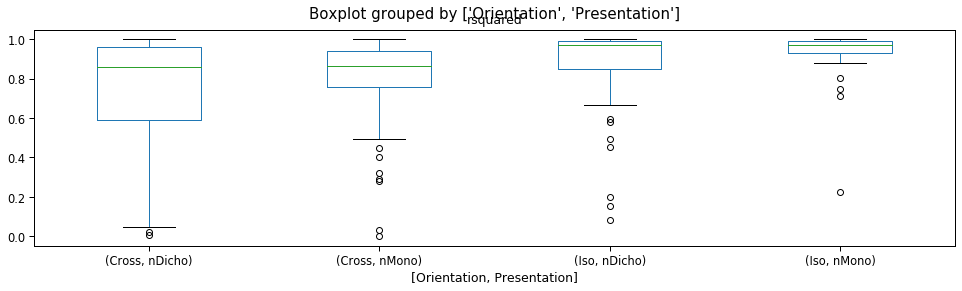

In [82]:
lin_results.boxplot(column='rsquared', by=['Orientation', 'Presentation'], grid=False, figsize=(16, 4))

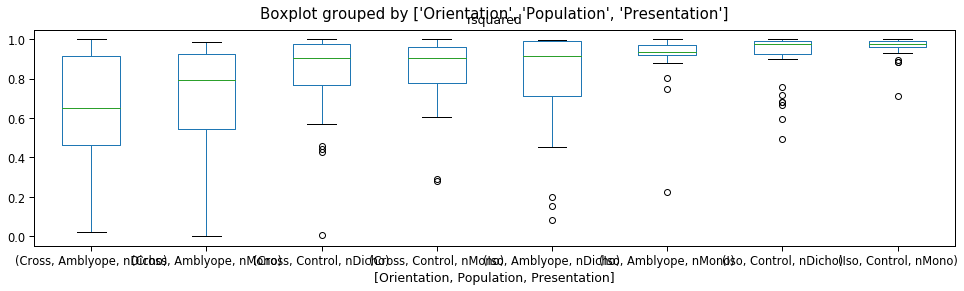

In [83]:
lin_results.boxplot(column='rsquared', by=['Orientation', 'Population', 'Presentation'], grid=False, figsize=(16, 4))

### Fit the log-logged data to see if that's better

In [84]:
log_results = groups_with_baseline.apply(utils.linear_fit_params, 'logRelMaskContrast', 'logThreshElev').reset_index()

log_results.rsquared.mean()

0.7417445472530506

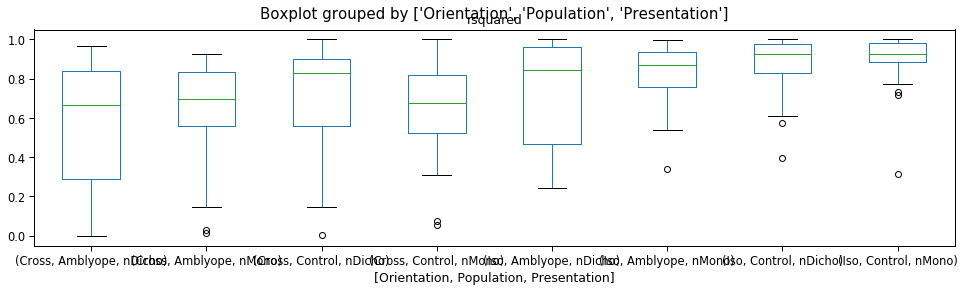

In [85]:
log_results.boxplot(column='rsquared', by=['Orientation', 'Population', 'Presentation'], grid=False, figsize=(16, 4))

## Conclusion: linear fits are overall better.

In [86]:
del log_results

## Identify subjects with negative slope (for Jian)

In [87]:
neg_slopes = lin_results[lin_results['slope']<0]
neg_slopes

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
12,SS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,6.210,1.023065,-0.006021,0.045044
14,SS,Cross,nDicho,Amblyope,jv,De,Amblyope-De,4.227,1.689517,-0.020405,0.181212
20,SS,Cross,nDicho,Amblyope,mv,De,Amblyope-De,5.981,1.260735,-0.020939,0.503098
22,SS,Cross,nDicho,Amblyope,rn,De,Amblyope-De,6.424,0.757355,-0.017022,0.021744
24,SS,Cross,nDicho,Amblyope,sd,De,Amblyope-De,6.262,0.706531,-0.017487,0.073372
53,SS,Cross,nDicho,Control,ms,Nde,Control-Nde,4.214,0.942228,-0.004734,0.622978
78,SS,Cross,nMono,Amblyope,jv,De,Amblyope-De,4.227,1.861288,-0.038142,0.319723
86,SS,Cross,nMono,Amblyope,rn,De,Amblyope-De,6.424,0.933673,-0.033097,0.494020
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827,1.006648,-0.013177,0.152790


In [88]:
neg_slopes.Subject.unique()

array(['cl', 'gd', 'jv', 'mv', 'rn', 'sd', 'ms', 'bi', 'ct'], dtype=object)

## Exclude bad fits (new 2019-02-25)

In [89]:
len(lin_results)

256

In [90]:
lin_results_exc = lin_results.groupby(['Task', 'Population']).apply(utils.remove_outliers_halfvar).reset_index(drop=True)

In [91]:
lin_results_exc.rsquared.min()

0.5030976163556411

In [92]:
lin_results_exc.Subject.value_counts().sum()

231

In [93]:
231/256

0.90234375

In [94]:
pp_subs_exc = lin_results_exc.Subject.unique()
print(f'There are {len(pp_subs_exc)} unique subjects who have at least one condition of data.')

There are 35 unique subjects who have at least one condition of data.


## Actually use the linear model to predict thresholds

In [95]:
lin_preds = groups_with_baseline.apply(utils.linear_fit_predictions, 'RelMaskContrast', 'ThreshElev').reset_index()

In [96]:
lin_preds.columns

Index(['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye',
       'Trace', 'BaselineThresh', 'RelMaskContrast', 'ThreshPred'],
      dtype='object')

In [97]:
lin_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.318,1.411635


In [98]:
plot_df = pd.merge(df_to_model, lin_preds, on=pp_gvars_base + ['RelMaskContrast'])
plot_df['ThreshUnnorm'] = (plot_df['ThreshElev']*plot_df['BaselineThresh']).round(2)
plot_df['ThreshPredUnnorm'] = (plot_df['ThreshPred']*plot_df['BaselineThresh']).round(2)

### Plot observed values and model fits

In [99]:
example_condition_df = plot_df[(plot_df.Orientation=='Iso') & 
                              (plot_df.Presentation=='nDicho')]
example_fit_plot_df = example_condition_df[example_condition_df.Subject=='gd']

example_fit_plot_df

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast,ThreshPred,ThreshUnnorm,ThreshPredUnnorm
579,gd,SS,nDicho,Iso,Nde,Amblyope,5.0,1.125,0.009,0.805,Amblyope-Nde,6.536,0.792,1,0.051153,-0.094204,0.636038,7.35,4.16
580,gd,SS,nDicho,Iso,Nde,Amblyope,10.0,1.215,0.010,1.610,Amblyope-Nde,6.536,1.460,2,0.084576,0.206826,1.243600,7.94,8.13
581,gd,SS,nDicho,Iso,Nde,Amblyope,18.0,1.733,0.010,2.899,Amblyope-Nde,6.536,2.632,3,0.238799,0.462248,2.216453,11.33,14.49
582,gd,SS,nDicho,Iso,Nde,Amblyope,32.0,3.494,0.016,5.153,Amblyope-Nde,6.536,4.526,4,0.543323,0.712060,3.917625,22.84,25.61
583,gd,SS,nDicho,Iso,Nde,Amblyope,45.0,5.944,0.007,7.246,Amblyope-Nde,6.536,7.257,5,0.774079,0.860098,5.497285,38.85,35.93
680,gd,SS,nDicho,Iso,De,Amblyope,5.0,0.787,0.009,0.765,Amblyope-De,6.210,0.878,2,-0.104025,-0.116339,1.026201,4.89,6.37
681,gd,SS,nDicho,Iso,De,Amblyope,10.0,1.121,0.008,1.530,Amblyope-De,6.210,1.496,3,0.049606,0.184691,1.042671,6.96,6.47
682,gd,SS,nDicho,Iso,De,Amblyope,18.0,1.294,0.012,2.754,Amblyope-De,6.210,2.500,4,0.111934,0.439964,1.069024,8.04,6.64
683,gd,SS,nDicho,Iso,De,Amblyope,32.0,1.173,0.007,4.896,Amblyope-De,6.210,4.330,5,0.069298,0.689841,1.115141,7.28,6.93
684,gd,SS,nDicho,Iso,De,Amblyope,45.0,1.036,0.009,6.885,Amblyope-De,6.210,6.995,6,0.015360,0.837904,1.157963,6.43,7.19


In [100]:
s.group_facet_plots(example_fit_plot_df, s.subject_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TOPS.pdf",
                    ['Task','Orientation','Presentation',"Subject"], #each combo of this gets its own page
                    row='Presentation', col="Population",# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Eye",
                    yerr='ThreshElev_SE',
                    fmt_obs='o',
                    fmt_pred=':',
                    Ycol="ThreshPred")

RelMaskContrast ThreshElev [0.009 0.01  0.01  0.016 0.007] ThreshPred
RelMaskContrast ThreshElev [0.009 0.008 0.012 0.007 0.009] ThreshPred
Plotting SS.Iso.nDicho.gd
Plots saved at plots/redo-202001-mean_occ_all-fixeyes/SS_regressions_combinedplots_n35_TOPS.pdf


### Figure 3: Make example fit plot using new functions that allow more specificity

In [101]:
print(colors_amb)

['#3274a1', '#72b4e1']


In [229]:
example_fit_groups = example_condition_df.groupby(['Task','Orientation','Presentation','Eye','Subject'])
with s.PdfPages(f"{plot_dir}/figure03_example_fit.pdf") as pdf:
    fig, axs = plt.subplots(2, figsize=(8,7))
    for (i, ax) in enumerate(axs):
        if i==0: #unnormalized data
            x="MaskContrast"
            y="ThreshUnnorm"
            ypred="ThreshPredUnnorm"
        else:
            x="RelMaskContrast"
            y="ThreshElev"
            ypred="ThreshPred"
        for gv, gr in example_fit_groups:
            if "Nde" in gv:
                fmt = "^"
                color = colors_amb[1]
                label = "NDE"
            else:
                fmt="o"
                color=colors_amb[0]
                label="DE"
            ax.errorbar(data=gr, x=x, y=y, yerr=None,fmt=fmt,color=color,label=f"{label} (observed)")
            ax.errorbar(data=gr, x=x, y=ypred, yerr=None, fmt=':',color=color,label=f"{label} (predicted)")
            if i==0: # show baselines 
                ax.axhline(y=gr.BaselineThresh.iat[0], xmax=.01, color=color)
        ax.set_xscale('log')
        ax.get_xaxis().set_major_locator(tick.LogLocator(subs=[1,2,5]))
        ax.get_xaxis().set_major_formatter(tick.FormatStrFormatter("%g"))
        ax.set_yscale('log')
        ax.get_yaxis().set_major_locator(tick.LogLocator(subs=[1,2,5]))
        ax.get_yaxis().set_major_formatter(tick.FormatStrFormatter("%g"))

        if i==0: #unnormalized data
            ax.set_xlabel("Surround Contrast (C%)")
            ax.set_ylabel("Contrast discrimination threshold (C%)")
        else:
            ax.set_xlabel("Relative Surround Contrast\n(multiples of baseline)")
            ax.set_ylabel("Threshold Elevation\n(multiples of baseline)")
            ax.axhline(y=1, ls='dotted', color='grey')
            ax.axvline(x=2, ls='dotted', color='red')
        #ax.legend()
    fig.subplots_adjust(hspace=.6)
    pdf.savefig(fig)
    plt.close('all')

## Now exclude the predictions for the bad fits

In [103]:
lin_results.Orientation.value_counts()

Iso      128
Cross    128
Name: Orientation, dtype: int64

In [104]:
lin_results_exc.Orientation.value_counts()

Iso      122
Cross    109
Name: Orientation, dtype: int64

In [105]:
lin_results_exc.Population.value_counts()

Control     145
Amblyope     86
Name: Population, dtype: int64

In [106]:
lin_results.Population.value_counts()

Control     152
Amblyope    104
Name: Population, dtype: int64

In [107]:
comb_rsq_preds = pd.merge(lin_results_exc, lin_preds, on=pp_gvars_base)

In [108]:
comb_rsq_preds.rsquared.min()

0.5030976163556411

In [109]:
comb_rsq_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389,1.318,1.411635


In [110]:
comb_rsq_preds_noexc = pd.merge(lin_results, lin_preds, on=pp_gvars_base)

In [111]:
comb_rsq_preds_noexc.rsquared.min()

0.002508814671685511

In [112]:
comb_rsq_preds_noexc.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389,1.318,1.411635


### Pick an xvalue (RelMaskContrast) to evaluate models at

 * 2018-09-24: Abandoning Eunice's binning. Instead, try to figure out a good RelMaskContrast programatically.
   * Just looking at it via describe(), i'd say somewhere between 5 and 10 -- probably 6 (for SS) and 10 (for OS)
 * 2018-10-08: My previous approach was too subjective. Instead, evaluate model at various percentiles...
   * do this separately for Task, Orientation, Presentation (so pick 8 total numbers)
   * At this point it's easier to just use the statsmodels.ols functions maybe? The way it's currently done is a legacy that allows different models to be swapped in... which I hope to god is not going to be the direction we go in again.
   * nvm, used the lmfit solution since it returned a nicely formatted pfit df and is tested to work
   * Here I want to take the slope and y-int and calculate the model prediction at the specified percentiles above (0-1, increments of 0.2). So, first calculate the RelMC at each of those percentiles, then apply it like below.


In [113]:
percentile_bins = np.linspace(0, 1, num=11)

In [114]:
percentile_bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

#### Get the interpolated RelMaskContrasts for each regression line, i.e. the range of x-values

In [115]:
relmc_pcts_df = comb_rsq_preds.groupby(pp_gvars_base)['RelMaskContrast'].describe(percentiles=percentile_bins)

In [116]:
# fix stupid column naming from describe()
relmc_pcts_df.columns = [f"{int(float(col[:-1])):03d}" if col[-1]=="%" else col for col in relmc_pcts_df.columns]

In [117]:
relmc_pcts_df.columns

Index(['count', 'mean', 'std', 'min', '000', '010', '020', '030', '040', '050',
       '060', '070', '080', '090', '100', 'max'],
      dtype='object')

In [118]:
relmc_pcts_df = relmc_pcts_df.filter(regex='0|1')
relmc_pcts_df.head()

000  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh          
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.194   
                                                 Nde Amblyope-Nde 4.558           1.318   
                                         am      Nde Amblyope-Nde 7.834           1.328   
                                         bi      De  Amblyope-De  7.827           0.986   
                                                 Nde Amblyope-Nde 10.141          1.278   

                                                                                     010  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.7205   
                                                 Nde Amblyope-Nde 4.558           1.6342   
                                         am      Nde Amblyope-Nde 7.834           1.7528   
                                         bi      De  Amblyope-De  7.827           1.3804   
                                                 Nde Amblyope-Nde 10.141          1.7890   

                                                                                     020  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.2470   
                                                 Nde Amblyope-Nde 4.558           1.9504   
                                         am      Nde Amblyope-Nde 7.834           2.1776   
                                         bi      De  Amblyope-De  7.827           1.7748   
                                                 Nde Amblyope-Nde 10.141          2.3000   

                                                                                     030  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.7735   
                                                 Nde Amblyope-Nde 4.558           2.2666   
                                         am      Nde Amblyope-Nde 7.834           2.7618   
                                         bi      De  Amblyope-De  7.827           2.1692   
                                                 Nde Amblyope-Nde 10.141          2.8110   

                                                                                     040  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           4.5632   
                                                 Nde Amblyope-Nde 4.558           2.7408   
                                         am      Nde Amblyope-Nde 7.834           3.5054   
                                         bi      De  Amblyope-De  7.827           2.5636   
                                                 Nde Amblyope-Nde 10.141          3.3220   

                                                                                     050  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           5.4845   
                                                 Nde Amblyope-Nde 4.558           3.2940   
                                         am      Nde Amblyope-Nde 7.834           4.2490   
                                         bi      De  Amblyope-De  7.827           2.9580   
                                                 Nde Amblyope-Nde 10.141          3.8330   

                                                                                     060  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyop

In [119]:
relmc_pcts_df.columns

Index(['000', '010', '020', '030', '040', '050', '060', '070', '080', '090',
       '100'],
      dtype='object')

In [120]:
relmc_pcts_df_melted = relmc_pcts_df.reset_index().melt(id_vars=pp_gvars_base, var_name='percentile', value_name='RelMaskContrast_pct')

In [121]:
relmc_pcts_df_melted.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,000,2.194
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,000,1.318
2,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,000,1.328
3,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,000,0.986
4,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,000,1.278


In [122]:
predict_pcts_df = pd.merge(lin_results_exc, relmc_pcts_df_melted, on=pp_gvars_base)

In [123]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,000,2.1940
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,010,2.7205
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,020,3.2470
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,030,3.7735
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,040,4.5632


In [124]:
predict_pcts_df['percentile'] = predict_pcts_df['percentile'].astype(int)
predict_pcts_df['RelMaskContrast_pct'] = predict_pcts_df['RelMaskContrast_pct'].astype(float)
predict_pcts_df['relmc_bin'] = (np.around(predict_pcts_df['RelMaskContrast_pct'])).astype(int)
predict_pcts_df['ThreshElev_pct'] = (predict_pcts_df['y_int'] + (predict_pcts_df['RelMaskContrast_pct']*predict_pcts_df['slope'])).astype('float')

In [125]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,0,2.1940,2,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,10,2.7205,3,0.751589
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,20,3.2470,3,0.760684
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,30,3.7735,4,0.769779
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,40,4.5632,5,0.783421


In [126]:
predict_pcts_df.rsquared.min()

0.5030976163556411

In [127]:
gvars_test = ['Task','Orientation','Presentation','Population']
# equal_var=False makes it Welch's t-test, which does not assume the groups have equal variance
selected_bin_df = utils.find_pct_to_predict(predict_pcts_df, gvars_test,
                    'relmc_bin', 'ThreshElev_pct', test_func=st.ttest_ind, equal_var=False)

There are 20 bins in this condition.
1
10 DE obs, 21 NDE obs
p-value: 0.0015354314
1
10 DE obs, 21 NDE obs
p-value: 0.0015354314
2
13 DE obs, 28 NDE obs
p-value: 0.0001217267
3
10 DE obs, 17 NDE obs
p-value: 0.0026591129
4
8 DE obs, 14 NDE obs
p-value: 0.0073737492
5
8 DE obs, 12 NDE obs
p-value: 0.0344970562
6
4 DE obs, 13 NDE obs
p-value: 0.0082892146
7
2 DE obs, 8 NDE obs
p-value: 0.0336034718
8
3 DE obs, 4 NDE obs
p-value: 0.3643803918
9
3 DE obs, 5 NDE obs
p-value: 0.0423860511
10
1 DE obs, 4 NDE obs
p-value: nan
11
1 DE obs, 4 NDE obs
p-value: nan
12
2 DE obs, 3 NDE obs
p-value: 0.3205767408
13
A group with no obs, skipping
14
A group with no obs, skipping
15
1 DE obs, 2 NDE obs
p-value: nan
16
A group with no obs, skipping
17
A group with no obs, skipping
19
A group with no obs, skipping
21
A group with no obs, skipping
24
A group with no obs, skipping
relmc_bin 2 has lowest p-value.

There are 20 bins in this condition.
1
10 DE obs, 21 NDE obs
p-value: 0.0015354314
1
10 DE obs,

//anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


9
7 DE obs, 7 NDE obs
p-value: 0.6129804962
10
6 DE obs, 10 NDE obs
p-value: 0.3569340741
11
3 DE obs, 8 NDE obs
p-value: 0.1567434426
12
5 DE obs, 5 NDE obs
p-value: 0.4204986492
13
4 DE obs, 5 NDE obs
p-value: 0.0351302295
14
3 DE obs, 3 NDE obs
p-value: 0.5147506073
15
4 DE obs, 5 NDE obs
p-value: 0.1457780541
16
1 DE obs, 4 NDE obs
p-value: nan
17
1 DE obs, 3 NDE obs
p-value: nan
18
2 DE obs, 1 NDE obs
p-value: nan
19
1 DE obs, 4 NDE obs
p-value: nan
20
1 DE obs, 2 NDE obs
p-value: nan
21
2 DE obs, 1 NDE obs
p-value: nan
22
A group with no obs, skipping
23
A group with no obs, skipping
25
A group with no obs, skipping
relmc_bin 13 has lowest p-value.

There are 20 bins in this condition.
1
Not in suppression, mean of both eyes is < 1.
1
Not in suppression, mean of both eyes is < 1.
2
21 DE obs, 19 NDE obs
p-value: 0.0000100009
3
13 DE obs, 15 NDE obs
p-value: 0.0061183441
4
15 DE obs, 10 NDE obs
p-value: 0.0089245450
5
10 DE obs, 8 NDE obs
p-value: 0.0704511526
6
12 DE obs, 5 NDE o

     Task Orientation Presentation Population Subject  Eye        Trace  \
1130   SS       Cross       nDicho    Control      ke  Nde  Control-Nde   
1185   SS       Cross       nDicho    Control      mk  Nde  Control-Nde   
1206   SS       Cross       nDicho    Control      ms  Nde  Control-Nde   
1264   SS       Cross       nDicho    Control      se  Nde  Control-Nde   
1273   SS       Cross       nDicho    Control      tj  Nde  Control-Nde   

      BaselineThresh     y_int     slope  rsquared  percentile  \
1130           5.952  0.921550  0.073264  0.593633          80   
1185           6.611  0.598751  0.055907  0.936383          80   
1206           4.214  0.942228 -0.004734  0.622978          70   
1264           7.081  0.619462  0.031038  0.768570         100   
1273           5.006  0.664124  0.018170  0.709208          80   

      RelMaskContrast_pct  relmc_bin  ThreshElev_pct  BinNumberToPred  
1130              13.2720         13        1.893911               13  
1185    

In [128]:
g_TOP = selected_bin_df.groupby(['Task', 'Orientation', 'Presentation'])
def set_relmctopred_to_amb_val(g):
    ambs = g[g['Population']=='Amblyope']
    assert(np.all(ambs['RelMCToPred']==ambs['RelMCToPred'].iat[0]))
    assert(np.all(ambs['BinNumberToPred']==ambs['BinNumberToPred'].iat[0]))
    g['RelMCToPred'] = ambs['RelMCToPred'].iat[0]
    g['BinNumberToPred'] = ambs['BinNumberToPred'].iat[0]
    return g
selected_bin_df = g_TOP.apply(set_relmctopred_to_amb_val).reset_index()

In [129]:
selected_bin_df.groupby(gvars_test)['RelMCToPred','ThreshElev_pct'].describe()

RelMCToPred                           \
                                               count mean  std  min  25%  50%   
Task Orientation Presentation Population                                        
SS   Cross       nDicho       Amblyope         209.0  2.0  0.0  2.0  2.0  2.0   
                              Control          374.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         220.0  2.0  0.0  2.0  2.0  2.0   
                              Control          396.0  2.0  0.0  2.0  2.0  2.0   
     Iso         nDicho       Amblyope         242.0  2.0  0.0  2.0  2.0  2.0   
                              Control          407.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         275.0  2.0  0.0  2.0  2.0  2.0   
                              Control          418.0  2.0  0.0  2.0  2.0  2.0   

                                                   ThreshElev_pct            \
                                          75%  max          count      mean   
Task Orientation Presentation Population                                      
SS   Cross       nDicho       Amblyope    2.0  2.0          209.0  1.405147   
                              Control     2.0  2.0          374.0  1.270859   
                 nMono        Amblyope    2.0  2.0          220.0  1.016782   
                              Control     2.0  2.0          396.0  0.967216   
     Iso         nDicho       Amblyope    2.0  2.0          242.0  1.683927   
                              Control     2.0  2.0          407.0  1.974481   
                 nMono        Amblyope    2.0  2.0          275.0  1.437772   
                              Control     2.0  2.0          418.0  1.579746   

                                                                        \
                                               std       min       25%   
Task Orientation Presentation Population                                 
SS   Cross       nDicho       Amblyope    0.625566  0.676956  1.012935   
                              Control     0.445897  0.661363  0.939387   
                 nMono        Amblyope    0.314906  0.344715  0.846435   
                              Control     0.262268  0.430126  0.795938   
     Iso         nDicho       Amblyope    1.136489  0.260012  1.023047   
                              Control     0.890109  0.474386  1.343264   
                 nMono        Amblyope    0.824721  0.366306  0.861253   
                              Control     0.938111  0.432981  0.930592   

                                                                        
                                               50%       75%       max  
Task Orientation Presentation Population                                
SS   Cross       nDicho       Amblyope    1.226023  1.565376  4.674826  
                              Control     1.184204  1.470286  3.959224  
                 nMono        Amblyope    0.999258  1.168597  2.219274  
                              Control     0.930215  1.111265  2.078230  
     Iso         nDicho       Amblyope    1.322546  2.025497  6.242498  
                              Control     1.806443  2.409358  5.881773  
                 nMono        Amblyope    1.157459  1.806846  4.903989  
                              Control     1.300831  1.972276  6.689321

In [130]:
selected_bin_df['ThreshPredCritical'] = selected_bin_df['y_int'] + selected_bin_df['slope'] * selected_bin_df['RelMCToPred']
selected_bin_df['ThreshPredCriticalUnnorm'] = selected_bin_df['ThreshPredCritical'] * selected_bin_df['BaselineThresh']

In [131]:
selected_bin_df

,index,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct,BinNumberToPred,RelMCToPred,ThreshPredCritical,ThreshPredCriticalUnnorm
0,0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,0,2.1940,2,0.742493,2,2,0.739142,5.610087
1,1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,10,2.7205,3,0.751589,2,2,0.739142,5.610087
2,2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,20,3.2470,3,0.760684,2,2,0.739142,5.610087
3,3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,30,3.7735,4,0.769779,2,2,0.739142,5.610087
4,4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,40,4.5632,5,0.783421,2,2,0.739142,5.610087
5,5,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,50,5.4845,5,0.799337,2,2,0.739142,5.610087
6,6,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,60,6.4058,6,0.815252,2,2,0.739142,5.610087
7,7,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,70,7.5466,8,0.834960,2,2,0.739142,5.610087
8,8,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,80,9.1264,9,0.862251,2,2,0.739142,5.610087
9,9,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,90,10.7062,11,0.889542,2,2,0.739142,5.610087


In [132]:
individual_plot_df = selected_bin_df[(selected_bin_df.Subject=='sd') & (selected_bin_df.Presentation=='nDicho') &
                (selected_bin_df.Orientation=='Iso')]

### Melt the result of the modeling into long format for plotting

In [133]:
pfit_all_ppsub = pd.melt(selected_bin_df, id_vars=[*pp_gvars, 'rsquared'],
                    value_vars=['BaselineThresh', 'y_int', 'slope', 'ThreshPredCritical', 'ThreshPredCriticalUnnorm'],
                    var_name='measure')
pfit_all_ppsub = pfit_all_ppsub[pfit_all_ppsub.Subject != 'ah']
pfit_all_ppsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,rsquared,measure,value
22,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,0.878492,BaselineThresh,7.834
23,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,0.878492,BaselineThresh,7.834
24,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,0.878492,BaselineThresh,7.834
25,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,0.878492,BaselineThresh,7.834
26,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,0.878492,BaselineThresh,7.834


In [134]:
pp_stats = pfit_all_ppsub[(pfit_all_ppsub.measure=="ThreshPredCritical")].drop_duplicates()

In [135]:
pp_slopes = pfit_all_ppsub[pfit_all_ppsub.measure=="slope"].drop_duplicates()

In [136]:
pp_stats.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace','Subject','measure'])['value'].describe(percentiles=[.5])

count  \
Task Orientation Presentation Population Eye Trace        Subject measure                     
SS   Cross       nDicho       Amblyope   De  Amblyope-De  bi      ThreshPredCritical    1.0   
                                                          cl      ThreshPredCritical    1.0   
                                                          eg      ThreshPredCritical    1.0   
                                                          li      ThreshPredCritical    1.0   
                                                          mv      ThreshPredCritical    1.0   
                                         Nde Amblyope-Nde am      ThreshPredCritical    1.0   
                                                          bi      ThreshPredCritical    1.0   
                                                          cl      ThreshPredCritical    1.0   
                                                          eg      ThreshPredCritical    1.0   
                                                          em      ThreshPredCritical    1.0   
                                                          gd      ThreshPredCritical    1.0   
                                                          jv      ThreshPredCritical    1.0   
                                                          li      ThreshPredCritical    1.0   
                                                          mg      ThreshPredCritical    1.0   
                                                          mv      ThreshPredCritical    1.0   
                                                          rn      ThreshPredCritical    1.0   
                                                          sd      ThreshPredCritical    1.0   
                              Control    De  Control-De   ai      ThreshPredCritical    1.0   
                                                          cr      ThreshPredCritical    1.0   
                                                          ct      ThreshPredCritical    1.0   
                                                          ei      ThreshPredCritical    1.0   
                                                          es      ThreshPredCritical    1.0   
                                                          gm      ThreshPredCritical    1.0   
                                                          kw      ThreshPredCritical    1.0   
                                                          ls      ThreshPredCritical    1.0   
                                                          mk      ThreshPredCritical    1.0   
                                                          ms      ThreshPredCritical    1.0   
                                                          nl      ThreshPredCritical    1.0   
                                                          se      ThreshPredCritical    1.0   
                                                          tm      ThreshPredCritical    1.0   
...                                                                                     ...   
     Iso         nMono        Control    De  Control-De   kw      ThreshPredCritical    1.0   
                                                          ls      ThreshPredCritical    1.0   
                                                          mk      ThreshPredCritical    1.0   
                                                          ms      ThreshPredCritical    1.0   
                                                          nl      ThreshPredCritical    1.0   
                                                          se      ThreshPredCritical    1.0   
                                                          tm      ThreshPredCritical    1.0   
                                                          yl      ThreshPredCritical    1.0   
                                         Nde Control-Nde  ai      ThreshPredCritical    1.0   
                                                          ap      ThreshPredCritical    1.0   
 

In [137]:
def test_suppression_diffs(g):
    ndes = np.unique(g[g.Eye=='Nde']['value'])
    des = np.unique(g[g.Eye=='De']['value'])
    #g.hist()
    print(len(ndes), ' ', len(des))
    print(st.ttest_ind(ndes, des))
    return st.ttest_ind(ndes, des)

gs = pp_stats.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'measure'])
for gv, g in gs:
    if gv[-1] == 'ThreshPredCritical':
        print(gv)
        test_suppression_diffs(g)
        #test_suppression_diffs_withinsubject(g)

('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical')
12   5
Ttest_indResult(statistic=0.7299650938121938, pvalue=0.47665772477441826)
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical')
20   14
Ttest_indResult(statistic=1.2480432813668088, pvalue=0.2210704712855009)
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical')
8   10
Ttest_indResult(statistic=2.168794020213688, pvalue=0.04551308680649891)
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical')
22   14
Ttest_indResult(statistic=0.017806935418218775, pvalue=0.9858969600137633)
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical')
11   9
Ttest_indResult(statistic=1.6457568302805612, pvalue=0.11716250467180517)
('SS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical')
22   15
Ttest_indResult(statistic=0.8733956494629632, pvalue=0.3884006830868616)
('SS', 'Iso', 'nMono', 'Amblyope', 'ThreshPredCritical')
11   12
Ttest_indResult(statistic=1.629629014967295, pvalue=0.11808930769833965)
('SS', 'Iso', 'nMono', '

## Subset to include only (GABA and psychophyics) subjects

In [138]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [139]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.\n{gaba_and_pp_subjs_thistask}")

Of the 24 subjects with both GABA and psychophysics data, 23 have both for task SS.
['ai' 'am' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw'
 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']


### Remove subjects we don't have data on both GABA/PP for

In [140]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
amb_subjs = (gdf[gdf.Population=='Persons with Amblyopia'])
print(f'Of the {len(gdf)} subjects with GABA and {task} data, {len(amb_subjs)} are Amblyopes.')
n_this_task = len(gdf)

Of the 22 subjects with GABA and SS data, 8 are Amblyopes.


In [141]:
stats_thistask = lin_results_exc[lin_results_exc.Subject.isin(gaba_and_pp_subjs_thistask)].groupby(['Subject'])['rsquared'].describe()

In [142]:
stats_thistask

,count,mean,std,min,25%,50%,75%,max
Subject,,,,,,,,
ai,8.0,0.935161,0.117607,0.659733,0.943784,0.986299,0.999719,0.999922
am,6.0,0.910557,0.067258,0.799772,0.887612,0.915914,0.949502,0.992865
bi,7.0,0.916000,0.164366,0.546837,0.952287,0.976332,0.992383,0.999488
cr,8.0,0.945987,0.058601,0.840411,0.904833,0.963965,0.997742,0.999292
ct,7.0,0.937913,0.077187,0.779726,0.926199,0.964989,0.985442,0.997392
dl,6.0,0.893841,0.092011,0.770530,0.821866,0.911476,0.969726,0.988424
ei,7.0,0.922415,0.140298,0.607023,0.954326,0.973990,0.983801,0.999641
em,7.0,0.885701,0.098248,0.745585,0.809151,0.921243,0.957915,0.998944
es,7.0,0.779242,0.124372,0.596832,0.697413,0.766640,0.881903,0.932588


In [143]:
n_gaba_and_pp_subjs_thistask * 8 - stats_thistask['count'].sum()

25.0

## Combine Psychophysics and GABA below

In [144]:
#Grab the GABA measure for each subject and append it to each observation for easy plotting
comb = pfit_all_ppsub.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
comb.drop_duplicates(inplace=True)

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]
print(len(comb), len(comb_gabappsub))

1115 765


In [145]:
comb_gabappsub.Subject.unique()

array(['bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd', 'ai', 'cr', 'ct',
       'dl', 'ei', 'es', 'gm', 'jd', 'kw', 'ls', 'mk', 'ms', 'nl', 'yl'],
      dtype=object)

### Do Spearman's R

In [146]:
spearman_df = comb_gabappsub[(comb_gabappsub.measure == 'BaselineThresh') | 
                             (comb_gabappsub.measure == 'ThreshPredCritical')]

In [147]:
spearman_df.Subject.unique()

array(['bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd', 'ai', 'cr', 'ct',
       'dl', 'ei', 'es', 'gm', 'jd', 'kw', 'ls', 'mk', 'ms', 'nl', 'yl'],
      dtype=object)

In [148]:
spearman_df.Trace = spearman_df.Trace.astype('category')
foo_temp = spearman_df.Trace.copy()
spearman_df.Trace.cat.reorder_categories(traces4, inplace=True)
assert(foo_temp.equals(spearman_df.Trace))
spearman_df.Trace.cat.rename_categories(traces_graph4, inplace=True)

//anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [149]:
plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure','Eye','Trace'])
for gv, gr in plot_groups:
    #if 'nDicho' in gv:
    print(gv)
    print(stats.spearmanr(gr.GABA, gr.value))
    if "ThreshPredCritical" in gv:
        print(gr)

('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh', 'De', 'Persons with\nAmblyopia, DE')
SpearmanrResult(correlation=-0.9999999999999999, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh', 'Nde', 'Persons with\nAmblyopia, NDE')
SpearmanrResult(correlation=-0.2142857142857143, pvalue=0.6103444156452669)
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical', 'De', 'Persons with\nAmblyopia, DE')
SpearmanrResult(correlation=0.9999999999999999, pvalue=nan)
     Task Orientation Presentation Population Subject Eye  \
7656   SS       Cross       nDicho   Amblyope      bi  De   
7755   SS       Cross       nDicho   Amblyope      li  De   

                            Trace  rsquared             measure     value  \
7656  Persons with\nAmblyopia, DE  0.546837  ThreshPredCritical  0.889669   
7755  Persons with\nAmblyopia, DE  0.512114  ThreshPredCritical  1.024744   

       GABA  
7656  0.205  
7755  0.216  
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical', 

In [150]:
iso_legend_img = plt.imread("/Users/smerdis/Dropbox/Documents/cal/silverlab/mrs-amblyopia/ss-iso-targetandmask.png")

In [151]:
iso_legend_img.shape

(320, 672, 4)

#### Figures 8 and 9

In [152]:
legend_axes_pos = [[0.1, 0.60, 0.15, 0.2], [0.6, 0.60, 0.15, 0.2],
                   [0.1, 0.10, 0.1, 0.15], [0.6, 0.10, 0.1, 0.15]]

In [153]:
facet_groups2 = spearman_df.groupby(['Task','Orientation','Presentation','measure'])
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}_facet_joint.pdf") as pdf:
    for gv, gr in facet_groups2:
        if "ThreshPredCritical" in gv:
            print(gv)
            if "Cross" in gv: # set a different ylim (etc) for cross and iso
                ylim = ((0.2, 4),(0.3,2.2))
            else:
                if "nMono" in gv:
                    ylim = ((0.2, 2),(0.2,2))
                else:
                    ylim = ((0.2, 4),(0.3,3.3))
            g = s.gaba_vs_psychophys_plot(gv, gr, 
                        legend_box=legend_axes_pos,
                        legend_img = True,
                        legend = False,
                        log = True,
                        sharex=False, sharey=False,
                        ylim = ylim,
                        row="Presentation", col="Population", hue="Trace",
                        palette=colors4,
                        n_boot=n_boot,
                        markers=['o','^','o','^'])#, legend=False)
            g.set_titles("") # top row is dichoptic
            g.fig.subplots_adjust(left=.1, right=.95, wspace=0.12)
            pdf.savefig(g.fig)
    plt.close('all')

('SS', 'Cross', 'nDicho', 'ThreshPredCritical')
('SS', 'Cross', 'nDicho', 'ThreshPredCritical')

Percentiles for individual eye correlations:
Amb DE 
Observed value of 1.000 is greater than 0.493 of bootstrap distribution, corresponding to p=0.99.
Amb NDE 
Observed value of -0.381 is greater than 0.167 of bootstrap distribution, corresponding to p=0.33.
Con DE 
Observed value of -0.154 is greater than 0.300 of bootstrap distribution, corresponding to p=0.60.
Con NDE 
Observed value of -0.077 is greater than 0.402 of bootstrap distribution, corresponding to p=0.80.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of -1.381 is greater than 0.084 of bootstrap distribution, corresponding to p=0.17.
Con NDE vs DE 
Observed value of 0.077 is greater than 0.576 of bootstrap distribution, corresponding to p=0.85.
Pop Amb vs Con 
Observed value of -1.458 is greater than 0.104 of bootstrap distribution, corresponding to p=0.21.
('SS', 'Cross', 'nMono', 'ThreshPredCritical

In [154]:
spearman_supp_df = spearman_df[spearman_df.measure=="ThreshPredCritical"]
supp_facet_groups = spearman_supp_df.groupby(['Task','Orientation','Presentation','measure'])

In [155]:
spearman_supp_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,rsquared,measure,value,GABA
7656,SS,Cross,nDicho,Amblyope,bi,De,"Persons with\nAmblyopia, DE",0.546837,ThreshPredCritical,0.889669,0.205
7667,SS,Cross,nDicho,Amblyope,bi,Nde,"Persons with\nAmblyopia, NDE",0.992124,ThreshPredCritical,1.201308,0.205
7722,SS,Cross,nDicho,Amblyope,em,Nde,"Persons with\nAmblyopia, NDE",0.930127,ThreshPredCritical,2.367282,0.185
7733,SS,Cross,nDicho,Amblyope,gd,Nde,"Persons with\nAmblyopia, NDE",0.988296,ThreshPredCritical,0.918366,0.197
7744,SS,Cross,nDicho,Amblyope,jv,Nde,"Persons with\nAmblyopia, NDE",0.865440,ThreshPredCritical,0.297554,0.201


In [156]:
comb_gabappsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,rsquared,measure,value,GABA
33,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,0.546837,BaselineThresh,7.827,0.205
44,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,0.992124,BaselineThresh,10.141,0.205
99,SS,Cross,nDicho,Amblyope,em,Nde,Amblyope-Nde,0.930127,BaselineThresh,6.014,0.185
110,SS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,0.988296,BaselineThresh,6.536,0.197
121,SS,Cross,nDicho,Amblyope,jv,Nde,Amblyope-Nde,0.865440,BaselineThresh,4.764,0.201


In [157]:
spearman_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,rsquared,measure,value,GABA
33,SS,Cross,nDicho,Amblyope,bi,De,"Persons with\nAmblyopia, DE",0.546837,BaselineThresh,7.827,0.205
44,SS,Cross,nDicho,Amblyope,bi,Nde,"Persons with\nAmblyopia, NDE",0.992124,BaselineThresh,10.141,0.205
99,SS,Cross,nDicho,Amblyope,em,Nde,"Persons with\nAmblyopia, NDE",0.930127,BaselineThresh,6.014,0.185
110,SS,Cross,nDicho,Amblyope,gd,Nde,"Persons with\nAmblyopia, NDE",0.988296,BaselineThresh,6.536,0.197
121,SS,Cross,nDicho,Amblyope,jv,Nde,"Persons with\nAmblyopia, NDE",0.865440,BaselineThresh,4.764,0.201


In [158]:
spearman_df.measure.unique()

array(['BaselineThresh', 'ThreshPredCritical'], dtype=object)

In [159]:
kelly_file = f"{plot_dir}/{task}_data_frame.csv"
spearman_df.to_csv(kelly_file)

### Orientation Selective Suppression

In [160]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace",
             "measure", "GABA"]
oss_gvars_combeyes = ["Task", "Presentation", "Population", "Subject", 
             "measure", "GABA"]

In [161]:
for gv, g in spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(oss_gvars):
    print(gv, g.Orientation.unique())

('SS', 'nDicho', 'Amblyope', 'bi', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.205) ['Cross']
('SS', 'nDicho', 'Amblyope', 'bi', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.205) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'em', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.185) ['Iso']
('SS', 'nDicho', 'Amblyope', 'em', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.185) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'gd', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.19699999999999998) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'jv', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.201) ['Iso']
('SS', 'nDicho', 'Amblyope', 'jv', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.201) ['Cross']
('SS', 'nDicho', 'Amblyope', 'li', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.21600000000000003) ['Cross']
('SS', 'nDicho', 'Amblyope', 'li', 'Nde', 'Persons with\nAmbly

In [162]:
spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(['Task', 'Orientation', 'Presentation', 'Population','Eye'])['value'].describe()

count      mean       std  \
Task Orientation Presentation Population Eye                              
SS   Cross       nDicho       Amblyope   De     2.0  0.957207  0.095512   
                                         Nde    8.0  1.118438  0.602485   
                              Control    De    12.0  0.920188  0.222444   
                                         Nde   12.0  1.000823  0.214008   
                 nMono        Amblyope   De     6.0  0.845055  0.131815   
                                         Nde    5.0  0.969276  0.211546   
                              Control    De    12.0  0.763950  0.153710   
                                         Nde   14.0  0.773161  0.159849   
     Iso         nDicho       Amblyope   De     5.0  0.826099  0.143298   
                                         Nde    7.0  1.210034  0.525613   
                              Control    De    13.0  1.162128  0.526390   
                                         Nde   14.0  1.299467  0.409784   
                 nMono        Amblyope   De     8.0  0.866610  0.216900   
                                         Nde    7.0  0.974545  0.213291   
                              Control    De    14.0  0.759316  0.205264   
                                         Nde   14.0  0.791336  0.181914   

                                                   min       25%       50%  \
Task Orientation Presentation Population Eye                                 
SS   Cross       nDicho       Amblyope   De   0.889669  0.923438  0.957207   
                                         Nde  0.297554  0.855251  1.097689   
                              Control    De   0.566634  0.752102  0.902277   
                                         Nde  0.710565  0.836442  0.987619   
                 nMono        Amblyope   De   0.618131  0.808101  0.855103   
                                         Nde  0.601685  0.988664  1.047289   
                              Control    De   0.531982  0.659041  0.782763   
                                         Nde  0.469253  0.707193  0.755307   
     Iso         nDicho       Amblyope   De   0.683123  0.722384  0.788769   
                                         Nde  0.454030  0.906793  1.282176   
                              Control    De   0.180381  0.877780  1.097869   
                                         Nde  0.833085  0.986137  1.285265   
                 nMono        Amblyope   De   0.572492  0.657065  0.920236   
                                         Nde  0.606465  0.878960  1.045415   
                              Control    De   0.472317  0.610172  0.750564   
                                         Nde  0.506221  0.678647  0.748844   

                                                   75%       max  
Task Orientation Presentation Population Eye                      
SS   Cross       nDicho       Amblyope   De   0.990975  1.024744  
                                         Nde  1.226792  2.367282  
                              Control    De   1.116148  1.198372  
                                         Nde  1.092446  1.458876  
                 nMono        Amblyope   De   0.941145  0.979736  
                                         Nde  1.082916  1.125824  
                              Control    De   0.853101  1.040694  
                                         Nde  0.896052  0.976262  
     Iso         nDicho       Amblyope   De   0.900248  1.035972  
                                         Nde  1.418028  2.084390  
                              Control    De   1.501505  2.191057  
                                         Nde  1.340348  2.269123  
                 nMono        Amblyope   De   1.014116  1.160384  
                                         Nde  1.119914  1.172186  
                              Control    De   0.924252  1.102926  
                                         Nde  0.869298  1.233350

In [163]:
spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(['Task', 'Presentation', 'Population','Eye'])['Subject'].describe()

count unique top freq
Task Presentation Population Eye                      
SS   nDicho       Amblyope   De      7      7  jv    1
                             Nde    15      8  em    2
                  Control    De     25     14  ai    2
                             Nde    26     14  ai    2
     nMono        Amblyope   De     14      8  em    2
                             Nde    12      7  sd    2
                  Control    De     26     14  ai    2
                             Nde    28     14  ai    2

In [164]:
oss_df = spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(oss_gvars).apply(utils.calculate_orientation_selective_suppression).reset_index()

Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0805794306213783
Iso/Cross ratio: nan
Iso/Cross ratio: 0.8804992773062317
Iso/Cross ratio: 1.6746546243888554
Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: 0.3777062353868689
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2225842451824867
Iso/Cross ratio: nan
Iso/Cross ratio: 0.9855669521500559
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0054249110747602
Iso/Cross ratio: 1.441081746125601
Iso/Cross ratio: 1.4101357218055621
Iso/Cross ratio: 0.3183386415959459
Iso/Cross ratio: 0.7860277350761017
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0334808785607723
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2625513903058483
Iso/Cross ratio: 1.3991192980351077
Iso/Cross ratio: 1.1074330346930361
Iso/Cross ratio: 1.4973547772549172
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2271654371200194
Iso/Cross ratio: 1.2351557611759358
Iso/Cross ratio: nan
Iso/Cross ratio: 2.2838663786421733
Iso/Cross ratio: 1.121263370574786
Iso/Cross

In [165]:
print(np.count_nonzero(np.isnan(oss_df.value)), len(oss_df.value))

11901 11968


In [166]:
oss_df[~np.isnan(oss_df.value)]

,Task,Presentation,Population,Subject,Eye,Trace,measure,GABA,value
230,SS,nDicho,Amblyope,bi,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.205,1.080579
901,SS,nDicho,Amblyope,em,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.185,0.880499
1178,SS,nDicho,Amblyope,gd,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.197,1.674655
1866,SS,nDicho,Amblyope,li,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.216,0.377706
2139,SS,nDicho,Amblyope,mg,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.217,1.222584
2675,SS,nDicho,Amblyope,rn,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.200,0.985567
2806,SS,nDicho,Amblyope,sd,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.187,1.005425
3042,SS,nDicho,Control,ai,De,"Normally-sighted\npersons, DE",ThreshPredCritical,0.223,1.441082
3127,SS,nDicho,Control,ai,Nde,"Normally-sighted\npersons, NDE",ThreshPredCritical,0.223,1.410136
3305,SS,nDicho,Control,cr,De,"Normally-sighted\npersons, DE",ThreshPredCritical,0.201,0.318339


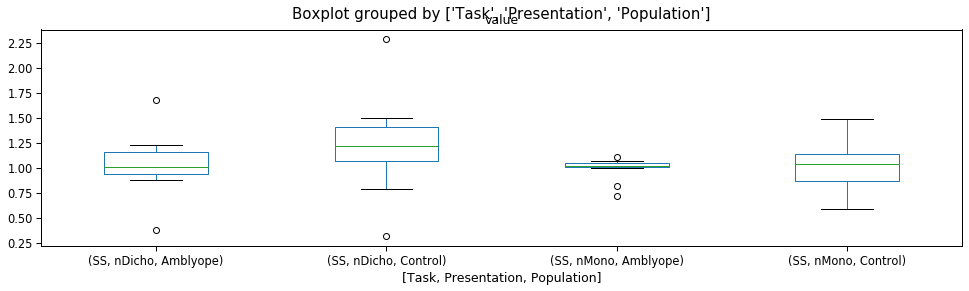

In [167]:
oss_df.boxplot(column='value', by=['Task','Presentation','Population'],
               grid=False, figsize=(16, 4))

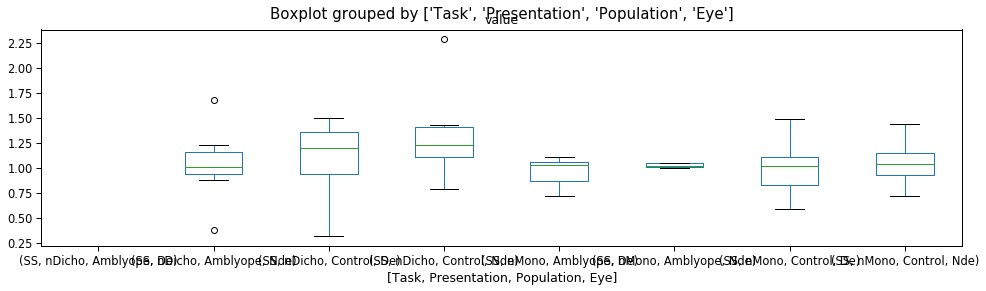

In [168]:
oss_df.boxplot(column='value', by=['Task','Presentation','Population','Eye'],
               grid=False, figsize=(16, 4))

In [169]:
oss_df.groupby(['Task', 'Presentation', 'Population','Eye'])['value'].describe()

count      mean       std       min  \
Task Presentation Population Eye                                        
SS   nDicho       Amblyope   De     0.0       NaN       NaN       NaN   
                             Nde    7.0  1.032431  0.388502  0.377706   
                  Control    De    11.0  1.116649  0.338898  0.318339   
                             Nde   12.0  1.287269  0.362879  0.786028   
     nMono        Amblyope   De     6.0  0.957098  0.157721  0.711143   
                             Nde    5.0  1.022666  0.021424  0.998211   
                  Control    De    12.0  0.991415  0.257819  0.580772   
                             Nde   14.0  1.039529  0.195072  0.715935   

                                       25%       50%       75%       max  
Task Presentation Population Eye                                          
SS   nDicho       Amblyope   De        NaN       NaN       NaN       NaN  
                             Nde  0.933033  1.005425  1.151582  1.674655  
                  Control    De   0.940048  1.200049  1.360375  1.497355  
                             Nde  1.105861  1.224489  1.411019  2.283866  
     nMono        Amblyope   De   0.864115  1.024349  1.054112  1.108008  
                             Nde  1.007945  1.017751  1.041180  1.048243  
                  Control    De   0.828919  1.014599  1.105571  1.486312  
                             Nde  0.927263  1.035547  1.143886  1.440743

In [170]:
for gv, g in oss_df.groupby(['Task', 'Presentation', 'Population','Eye']):
    print(gv)#, g, sep='\n')
    print(st.ttest_1samp(g['value'], popmean=1, nan_policy='omit'))

('SS', 'nDicho', 'Amblyope', 'De')
Ttest_1sampResult(statistic=masked, pvalue=masked)
('SS', 'nDicho', 'Amblyope', 'Nde')
Ttest_1sampResult(statistic=0.22085843740820543, pvalue=0.8325265415663132)
('SS', 'nDicho', 'Control', 'De')
Ttest_1sampResult(statistic=1.141589374533609, pvalue=0.2802239650794021)
('SS', 'nDicho', 'Control', 'Nde')
Ttest_1sampResult(statistic=2.742316292996574, pvalue=0.019151968328478295)
('SS', 'nMono', 'Amblyope', 'De')
Ttest_1sampResult(statistic=-0.6662954676462207, pvalue=0.5347275413950384)
('SS', 'nMono', 'Amblyope', 'Nde')
Ttest_1sampResult(statistic=2.365729454004665, pvalue=0.07717923918905874)
('SS', 'nMono', 'Control', 'De')
Ttest_1sampResult(statistic=-0.1153509834772772, pvalue=0.9102457072174562)
('SS', 'nMono', 'Control', 'Nde')
Ttest_1sampResult(statistic=0.7581942121706292, pvalue=0.46185931620148535)


In [171]:
def tt_pval(df):
    ttr = st.ttest_1samp(df['value'], popmean=1, nan_policy='omit')
    pval = ttr.pvalue
    return pd.Series(pval, ['pvalue'])

### OSS t-tests and results here

#### First limit to Controls and non-nans only

In [172]:
oss_df = oss_df[#(oss_df['Population'] == 'Control') & 
                (~np.isnan(oss_df['value']))]
oss_df['measure'] = 'OSSSRatio'

In [173]:
for gv, g in oss_df.groupby(['Task', 'Presentation', 'Population']):
    print(gv, np.unique(g['Subject']))#, g, sep='\n')
    print(st.ttest_1samp(g['value'], popmean=1, nan_policy='omit'))

('SS', 'nDicho', 'Amblyope') ['bi' 'em' 'gd' 'li' 'mg' 'rn' 'sd']
Ttest_1sampResult(statistic=0.2208584374082039, pvalue=0.8325265415663148)
('SS', 'nDicho', 'Control') ['ai' 'cr' 'ct' 'dl' 'ei' 'es' 'gm' 'jd' 'kw' 'ls' 'mk' 'ms' 'nl' 'yl']
Ttest_1sampResult(statistic=2.782704722479268, pvalue=0.010853136913789934)
('SS', 'nMono', 'Amblyope') ['bi' 'em' 'gd' 'li' 'mg' 'rn' 'sd']
Ttest_1sampResult(statistic=-0.3698923015343366, pvalue=0.7191760785333257)
('SS', 'nMono', 'Control') ['ai' 'cr' 'ct' 'dl' 'ei' 'es' 'gm' 'jd' 'kw' 'ls' 'mk' 'ms' 'nl' 'yl']
Ttest_1sampResult(statistic=0.3964661139395879, pvalue=0.6951251229206854)


In [174]:
oss_df.groupby(['Task', 'Presentation', 'Population'])[['GABA','value']].describe()

GABA                                           \
                             count      mean       std    min    25%    50%   
Task Presentation Population                                                  
SS   nDicho       Amblyope     7.0  0.201000  0.012689  0.185  0.192  0.200   
                  Control     23.0  0.204783  0.009390  0.193  0.197  0.203   
     nMono        Amblyope    11.0  0.200091  0.012965  0.185  0.187  0.200   
                  Control     26.0  0.205077  0.009368  0.193  0.197  0.203   

                                             value                      \
                                  75%    max count      mean       std   
Task Presentation Population                                             
SS   nDicho       Amblyope    0.21050  0.217   7.0  1.032431  0.388502   
                  Control     0.21050  0.223  23.0  1.205668  0.354458   
     nMono        Amblyope    0.21050  0.217  11.0  0.986901  0.117448   
                  Control     0.21075  0.223  26.0  1.017322  0.222785   

                                                                                
                                   min       25%       50%       75%       max  
Task Presentation Population                                                    
SS   nDicho       Amblyope    0.377706  0.933033  1.005425  1.151582  1.674655  
                  Control     0.318339  1.067312  1.213822  1.404628  2.283866  
     nMono        Amblyope    0.711143  1.003078  1.019271  1.044711  1.108008  
                  Control     0.580772  0.864030  1.035547  1.139274  1.486312

In [175]:
.354/(23**.5) # SEM of Control/Dicho (stdev from ^^^ / sqrt(n))

0.07381410257620447

In [176]:
oss_dicho = oss_df[oss_df.Presentation=="nDicho"]['value']
oss_mono = oss_df[oss_df.Presentation=="nMono"]['value']

In [177]:
oss_dicho[~np.isnan(oss_dicho)]

230     1.080579
901     0.880499
1178    1.674655
1866    0.377706
2139    1.222584
2675    0.985567
2806    1.005425
3042    1.441082
3127    1.410136
3305    0.318339
3390    0.786028
3529    1.033481
3670    1.262551
3712    1.399119
3797    1.107433
3992    1.497355
4262    1.227165
4347    1.235156
4474    2.283866
4666    1.121263
4932    1.200049
5017    1.213822
5207    0.951057
5292    1.172426
5346    1.321630
5431    1.413670
5485    0.929039
5570    1.427517
5886    0.877045
5971    1.101143
Name: value, dtype: float64

In [178]:
st.ttest_ind(oss_dicho, oss_mono, nan_policy='omit', equal_var=False)

Ttest_indResult(statistic=2.127486072781533, pvalue=0.03923517889559945)

In [179]:
def oss_mean_combeyes(df, **kwargs):
    if len(df.Eye.unique())==2:
        v1 = df[df.Eye=='Nde']['value'].iloc[0]
        v2 = df[df.Eye=='De']['value'].iloc[0]
        oss_mean_combeyes = np.mean([v1, v2])
    else:
        oss_mean_combeyes = np.nan
    print(f"OSS mean across eyes: {oss_mean_combeyes}")
    return pd.Series(oss_mean_combeyes, ['value'])

In [180]:
#for gv, g in oss_df.groupby(oss_gvars_combeyes):
#    print(gv, g, sep="\n")

In [181]:
oss_df_combeyes = oss_df.groupby(oss_gvars_combeyes).apply(oss_mean_combeyes).reset_index()

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: 1.4256087339655816
OSS mean across eyes: 0.5521831883360238
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: 1.253276166364072
OSS mean across eyes: nan
OSS mean across eyes: 1.2311605991479775
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: 1.2069355577737995
OSS mean across eyes: 1.061741548823194
OSS mean across eyes: 1.3676502549743175
OSS mean across eyes: 1.178277862790417
OSS mean across eyes: 0.9890943810514599
OSS mean across eyes: 1.0531094722586154
OSS mean across eyes: 1.0235890868730166
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: 0.9101706483876361
OSS mean across eyes: nan
OSS mean across eyes: 0.8761615575934487
OSS mean across eyes: 1.2428767509099434
OSS mean acro

In [182]:
oss_df_combeyes

,Task,Presentation,Population,Subject,measure,GABA,value
0,SS,nDicho,Amblyope,bi,OSSSRatio,0.205,NaN
1,SS,nDicho,Amblyope,em,OSSSRatio,0.185,NaN
2,SS,nDicho,Amblyope,gd,OSSSRatio,0.197,NaN
3,SS,nDicho,Amblyope,li,OSSSRatio,0.216,NaN
4,SS,nDicho,Amblyope,mg,OSSSRatio,0.217,NaN
5,SS,nDicho,Amblyope,rn,OSSSRatio,0.200,NaN
6,SS,nDicho,Amblyope,sd,OSSSRatio,0.187,NaN
7,SS,nDicho,Control,ai,OSSSRatio,0.223,1.425609
8,SS,nDicho,Control,cr,OSSSRatio,0.201,0.552183
9,SS,nDicho,Control,ct,OSSSRatio,0.208,NaN


In [183]:
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_oss.pdf") as pdf:
    temp_df = oss_df.copy()
    temp_df['Eye'] = temp_df['Eye'].astype('category')
    plot_groups = temp_df.groupby(['Task', 'Presentation', 'measure'])
    for gv, gr in plot_groups:
        #if "BaselineThresh" in gv: continue
        print(gv, np.all(np.isnan(gr['value'])))
        g2 = s.gaba_vs_psychophys_plot(gv, gr, 
                        col="Population", hue="Trace",
                        sharex=False, sharey=False, n_boot=10000,
                        palette=colors4, legend=False, legend_img=False, markers=['o','^','o','^'])
        g2.set_titles("") # top row is dichoptic
        g2.fig.subplots_adjust(left=.1, right=.95, wspace=0.12)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'nDicho', 'OSSSRatio') False
('SS', 'nDicho', 'OSSSRatio')

Percentiles for individual eye correlations:
Amb DE 
Observed value of nan is greater than 0.000 of bootstrap distribution, corresponding to p=0.00.
Amb NDE 
Observed value of 0.143 is greater than 0.607 of bootstrap distribution, corresponding to p=0.79.
Con DE 
Observed value of 0.533 is greater than 0.951 of bootstrap distribution, corresponding to p=0.10.
Con NDE 
Observed value of 0.203 is greater than 0.743 of bootstrap distribution, corresponding to p=0.51.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of nan is greater than 0.000 of bootstrap distribution, corresponding to p=0.00.
Con NDE vs DE 
Observed value of -0.330 is greater than 0.232 of bootstrap distribution, corresponding to p=0.46.
Pop Amb vs Con 
Observed value of nan is greater than 0.000 of bootstrap distribution, corresponding to p=0.00.
('SS', 'nMono', 'OSSSRatio') False
('SS', 'nMono', 'OSSSRatio')


/Users/smerdis/code/MRS_amblyopia/mrs_amblyopia/utils.py:239: RuntimeWarning: invalid value encountered in greater
  obs_pct = (np.count_nonzero(observed_corrs_ordered[i]>corrs_permute[i, :])/n_boot)
/Users/smerdis/code/MRS_amblyopia/mrs_amblyopia/utils.py:249: RuntimeWarning: invalid value encountered in greater
  obs_pct = (np.count_nonzero(real_diffs[i]>rs_permute[i, :])/n_boot)



Percentiles for individual eye correlations:
Amb DE 
Observed value of -0.086 is greater than 0.403 of bootstrap distribution, corresponding to p=0.81.
Amb NDE 
Observed value of -0.500 is greater than 0.175 of bootstrap distribution, corresponding to p=0.35.
Con DE 
Observed value of 0.469 is greater than 0.934 of bootstrap distribution, corresponding to p=0.13.
Con NDE 
Observed value of 0.508 is greater than 0.967 of bootstrap distribution, corresponding to p=0.07.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of -0.414 is greater than 0.271 of bootstrap distribution, corresponding to p=0.54.
Con NDE vs DE 
Observed value of 0.039 is greater than 0.540 of bootstrap distribution, corresponding to p=0.92.
Pop Amb vs Con 
Observed value of -0.453 is greater than 0.285 of bootstrap distribution, corresponding to p=0.57.


## Demographic stuff from KB

In [184]:
amb_data = demos[demos['group']==1].copy()
amb_data['motorGABA'] = pd.to_numeric(amb_data['motorGABA'].str.strip(), errors='coerce')
amb_data[["numID","initials","labelGroup","labelNDE","swapNDE_EY","acuityDE","acuityNDE",
          "iadLogMAR","occGABA","motorGABA"]]

,numID,initials,labelGroup,labelNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,PWA,right,0,-0.204120,0.116910,0.321030,0.198,0.215
2,6,as,PWA,left,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,PWA,right,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,PWA,left,0,-0.084939,1.176091,1.261030,0.184,NaN
6,12,cs,PWA,right,0,-0.096910,0.281030,0.377940,0.220,NaN
10,17,em,PWA,left,0,-0.096910,0.497121,0.594031,0.185,0.215
11,19,gd,PWA,left,0,-0.164000,0.398000,0.562000,0.197,0.208
14,24,jv,PWA,right,0,-0.085000,0.538000,0.623000,0.201,0.205
15,26,ks,PWA,left,0,-0.204000,0.261000,0.465000,0.207,0.211
17,28,li,PWA,left,0,0.000000,0.224000,0.224000,0.216,NaN


In [185]:
#tt_eyes = st.ttest_ind(amb_data['acuityDE'], amb_data['acuityNDE'], nan_policy='omit') # are the eyes different in acuity?
#print(tt_eyes)
#print("occ gaba vs acuityDE: ", st.spearmanr(amb_data['occGABA'], amb_data['acuityDE'], nan_policy='omit'))
#print("occ gaba vs acuityNDE: ", st.spearmanr(amb_data['occGABA'], amb_data['acuityNDE'], nan_policy='omit'))
print("occ gaba vs IAD: ", st.spearmanr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs IAD: ", st.spearmanr(amb_data['motorGABA'], amb_data['iadLogMAR'], nan_policy='omit'))

occ gaba vs IAD:  SpearmanrResult(correlation=-0.6365654208460114, pvalue=0.014373530547495347)
motor gaba vs IAD:  SpearmanrResult(correlation=0.21276694028802262, pvalue=0.5550759959985581)


In [186]:
print("occ gaba vs interocular acuity difference: ", st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs interocular acuity difference: ", np.corrcoef(amb_data['motorGABA'], amb_data['iadLogMAR'])[0,1])
#print("motor gaba vs interocular acuity difference: ", st.pearsonr(amb_data['motorGABA'], amb_data['iadLogMAR']))

occ gaba vs interocular acuity difference:  (-0.7056578245904566, 0.0048054407090632615)
motor gaba vs interocular acuity difference:  nan


In [187]:
print(amb_data['occGABA'], amb_data["motorGABA"], sep='\n')

0     0.198
2     0.217
3     0.205
4     0.184
6     0.220
10    0.185
11    0.197
14    0.201
15    0.207
17    0.216
19    0.217
23    0.207
24    0.200
25    0.187
Name: occGABA, dtype: float64
0     0.215
2     0.196
3     0.219
4       NaN
6       NaN
10    0.215
11    0.208
14    0.205
15    0.211
17      NaN
19    0.227
23    0.204
24    0.210
25      NaN
Name: motorGABA, dtype: float64


In [188]:
has_motor = amb_data[~np.isnan(amb_data['motorGABA'])]

In [189]:
len(amb_data['occGABA']), len(has_motor['motorGABA'])

(14, 10)

### Figure 5

Text(0, 0.5, 'Interocular acuity difference (logMAR)')

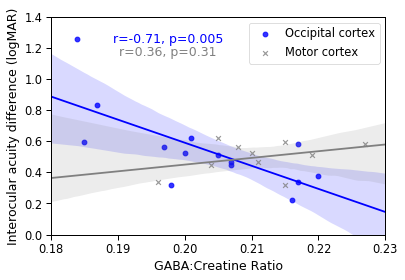

In [190]:
fig, ax = plt.subplots(1, 1)
ax.set_xlim(0.18, 0.23)
ax.set_ylim(0, 1.4)

sns.regplot(data=amb_data, x='occGABA', y='iadLogMAR', color='blue', marker='o', ax=ax, label='Occipital cortex')
r, p = st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR'])
ax.text(.35, 0.88, f"r={r:.2f}, p={p:.3f}", transform=ax.transAxes, fontdict={'color': 'blue'}, horizontalalignment='center')

sns.regplot(data=amb_data, x='motorGABA', y='iadLogMAR', color='grey', marker='x', ax=ax, label='Motor cortex')
r, p = st.pearsonr(has_motor['motorGABA'], has_motor['iadLogMAR'])
ax.text(.35, 0.82, f"r={r:.2f}, p={p:.2f}", transform=ax.transAxes, fontdict={'color': 'grey'}, horizontalalignment='center')

ax.legend()
ax.set_xlabel("GABA:Creatine Ratio")
ax.set_ylabel("Interocular acuity difference (logMAR)")

In [191]:
np.corrcoef(has_motor['motorGABA'], has_motor['iadLogMAR'])

array([[1.  , 0.36],
       [0.36, 1.  ]])

In [192]:
st.pearsonr(has_motor['motorGABA'], has_motor['iadLogMAR'])

(0.3602346498548906, 0.3065303272155514)